In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import os as os
import sys as sys
import glob as glob
import re as re
import numpy as np
import shutil as shutil

import paprika
print(paprika.__version__)

from paprika.amber import Simulation
from paprika import analysis
from paprika.restraints import DAT_restraint

import pytraj as pt
import parmed as pmd

2018-04-23_16:10:29_-0700-e34840d-0.0.3


In [3]:
import logging
from importlib import reload
reload(logging)

logging.basicConfig(filename='OA-G6.log', format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                    level=logging.DEBUG)
logging.info('Started logging...')
logging.info(paprika.__version__)

In [4]:
dummy_anchors = [':3', ':4', ':5']
host_anchors  = [':1@C26', ':1@C18', ':1@C8']

In [5]:
guest_anchors = [':2@C6', ':2@C1']

In [6]:
attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

windows = [len(attach_fractions), len(pull_string.split()), 0]

In [7]:
g6_complexes = glob.glob('./OA-G6*')

In [8]:
ntwprt = 206
itr_nstlim = 500000
paths = glob.glob(os.path.normpath(os.path.join('./OA-G6-0', 'AMBER', 'APR', 'windows', '*')))
window_list = [os.path.basename(i) for i in paths]
phase_dict = {'a': 'attach', 'p': 'pull', 'r': 'release'}

# End preamble

<IPython.core.display.Javascript object>


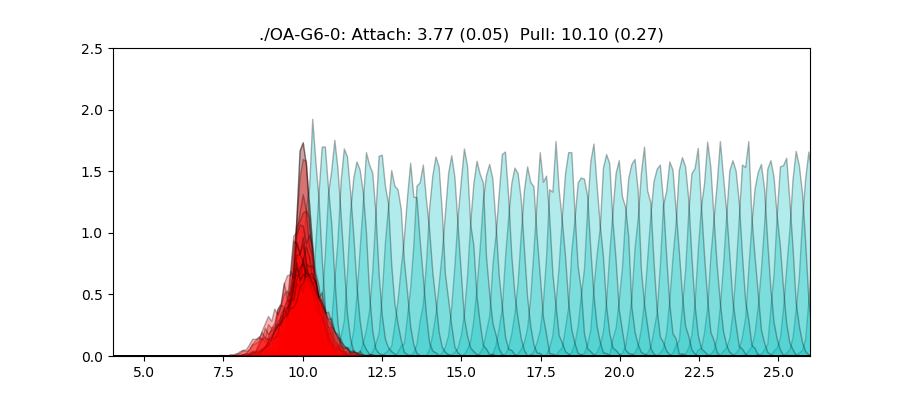

In [10]:
fig,axs = plt.subplots(figsize=(9,4))
axis = [4.0, 28.0, 0.0, 2.5]
zorder = len(window_list) + 2

# Converence threshold, kcal/mol (probably need separate for attach vs. pull)
convergence_thresh = {'attach': 0.006, 'pull': 0.03}
# Simulation steps per iteration


In [16]:
for complx in g6_complexes:
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')
    
    
    print(f'Simulating {complx}')

    # Store simulations here
    sim_list = []
    # Convergence check
    all_converged = {'attach': None, 'pull': None, 'release': None}

    # Loop of restart iterations
    for itr in range(50):
        # Checker for whether new data has been generated
        # Start with assumption of no new data
        new_data = False

        # Strings for restart iterations
        prev = "{:03.0f}".format(itr)
        curr = "{:03.0f}".format(itr+1)

        print('----- prev :'+prev+' cur: '+curr+' -----')
        sys.stdout.flush()

        # Loop through windows
        for i_win, win in enumerate(window_list):
            # Create some useful variables
            phase = phase_dict[win[0]]
            win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

            # If first time through, create simulation class and minimize
            if itr == 0:
                sim = Simulation()
                sim_list.append(sim)
                sim.executable = 'pmemd.cuda'
                sim.CUDA_VISIBLE_DEVICES = 2
                sim.path = win_path
                sim.topology = 'solvate.prmtop'
                sim.prefix = 'minimize'
                sim.inpcrd = 'solvate.rst7'
                sim.ref = 'solvate.rst7'
                sim.config_pbc_min()
                sim.cntrl['maxcyc'] = 500
                sim.cntrl['ncyc'] = 400
                sim.cntrl['ntr'] = 1
                sim.cntrl['restraint_wt'] = 50.0
                sim.cntrl['restraintmask'] = "'@DUM'"
                sim.restraint_file = 'disang.rest'
                # This might be an overwrite run, so check if minimize is done already
                if not os.path.isfile(win_path+'/minimize.rst7'):
                    sim.run()

                # Run Equilibration ... if we terminate early due to
                # box size changes, continue on from restart
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = ntwprt
                sim.cntrl['ntwr'] = 250
                sim.restraint_file = 'disang.rest'
                i = 0
                sim.prefix = 'equil.'+str(i)
                sim.inpcrd = 'minimize.rst7'
                sim.ref = 'solvate.rst7'
                # Run equil loop until we complete a full equil cycle.
                # Then copy the final rst7 to 'equil.rst7'
                while not os.path.isfile(win_path+'/equil.rst7') and i < 10:
                    if not os.path.isfile(win_path+'/'+sim.inpcrd):
                        break
                    sim.run()
                    with open(win_path+'/equil.'+str(i)+'.out') as f:
                        for line in f.readlines():
                            if re.search(' TIMINGS', line):
                                shutil.copy(win_path+'/'+sim.restart, win_path+'/equil.rst7')
                    i += 1
                    sim.prefix = 'equil.'+str(i)
                    sim.inpcrd = 'equil.'+str(i-1)+'.rst7'
                    sim.ref = 'solvate.rst7'

            # Setup production MD
            if itr == 0:
                sim.config_pbc_md()
                sim.executable = 'pmemd.cuda'
                sim.prefix = 'prod.'+curr
                #sim.input = 'mdin'
                sim.inpcrd = 'equil.rst7'
                sim.ref = 'solvate.rst7'
                sim.cntrl['ntx'] = 5
                sim.cntrl['irest'] = 1
                sim.cntrl['nstlim'] = itr_nstlim
                sim.cntrl['ntwr'] = itr_nstlim
                sim.cntrl['ntwx'] = 250
                sim.cntrl['ntwprt'] = ntwprt
                sim.cntrl['ntxo'] = 2
                sim.restraint_file = 'disang.rest'
                if not os.path.isfile(win_path+'/'+sim.restart):
                    sim.run()
                    new_data = True
                # From now on, don't assume we can access sim. Use
                # sim_list[i_win] instead. The reason is we aren't
                # gonna keep setting sim up each time and we've stored
                # them in sim_list
                sim = None            
            else:
                sim_list[i_win].prefix = 'prod.'+curr
                sim_list[i_win].inpcrd = 'prod.'+prev+'.rst7'
                sim_list[i_win].ref = 'solvate.rst7'
                #sim_list[i_win].input = 'mdin'
                # Check convergence to decide if we are "converged"
                convergence_val = fecalc.results[phase]['mbar-block']['convergence'][int(win[1:])]
                if convergence_val < convergence_thresh[phase]:
                    sim_list[i_win].converged = True
                if not sim_list[i_win].converged and not os.path.isfile(win_path+'/'+sim_list[i_win].restart):
                    sys.stdout.write(win+' ')
                    sim_list[i_win].run()
                    new_data = True
        print('')            
        
        # Collect data and compute free energy                   
        if itr == 0 or new_data:
            fecalc = analysis.fe_calc()
            fecalc.prmtop = stripped.topology
            fecalc.trajectory = 'prod.*.nc'
            fecalc.path = os.path.join(complx, 'AMBER', 'APR','windows')
            fecalc.restraint_list = guest_restraints
            fecalc.collect_data()
            fecalc.compute_free_energy()
            print('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
                complx,
                fecalc.results['attach']['mbar-block']['fe'],
                fecalc.results['attach']['mbar-block']['sem'],
                fecalc.results['pull']['mbar-block']['fe'],
                fecalc.results['pull']['mbar-block']['sem'],
            ))

        # Check overall Convergence
        for phase in "attach pull".split():
            convergence_vals = np.array(fecalc.results[phase]['mbar-block']['convergence'])
            if (convergence_vals < 0.05).all():
                all_converged[phase] = True
            else:
                all_converged[phase] = False
        
        # Update our plot.
        axs.clear()
        axs.axis(axis)
        axs.set_title('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f})'.format(
            complx,
            fecalc.results['attach']['mbar-block']['fe'],
            fecalc.results['attach']['mbar-block']['sem'],
            fecalc.results['pull']['mbar-block']['fe'],
            fecalc.results['pull']['mbar-block']['sem'],
        ))
        for phase in 'attach pull'.split():                    
            for i in range(len(fecalc.simulation_data[phase])):
                hist,bins = np.histogram(
                                fecalc.simulation_data[phase][i][0],
                                bins=301,
                                range=(0,30),
                                density=True
                            )
                center = (bins[:-1] + bins[1:]) / 2
                if phase == 'attach':
                    facecolor = 'r'
                else:
                    facecolor = 'c'
                axs.fill_between(
                    center, hist*0.0, hist, facecolor=facecolor, edgecolor='k',
                    alpha=0.3, zorder=zorder
                )
                zorder -= 1
            fig.canvas.draw()
            
        # If all phases are converged, we're done!
        if not False in all_converged.values():
            print("Done!")
            break

        sys.stdout.flush()

    

Set pull offset (9.98 A)


2018-04-24 09:22:28 AM Calculating attach targets and force constants...
2018-04-24 09:22:28 AM Attach, Method #3
2018-04-24 09:22:28 AM Calculating pull targets and force constants...
2018-04-24 09:22:28 AM Pull, Method #1
2018-04-24 09:22:28 AM Calculating release targets and force constants...
2018-04-24 09:22:28 AM No restraint info set for the release phase! Skipping...
2018-04-24 09:22:28 AM Number of attach windows = 15
2018-04-24 09:22:28 AM Number of pull windows = 46
2018-04-24 09:22:28 AM This restraint will be skipped in the release phase
2018-04-24 09:22:28 AM Assigning atom indices...
2018-04-24 09:22:28 AM There are 1 atoms in the mask :3  ...
2018-04-24 09:22:28 AM There are 1 atoms in the mask :2@C6  ...
2018-04-24 09:22:28 AM Calculating attach targets and force constants...
2018-04-24 09:22:28 AM Attach, Method #3
2018-04-24 09:22:28 AM Calculating pull targets and force constants...
2018-04-24 09:22:28 AM Pull, Method #1
2018-04-24 09:22:28 AM Calculating release ta

Simulating ./OA-G6-0
----- prev :000 cur: 001 -----


2018-04-24 09:22:28 AM Replacing ./OA-G6-0/AMBER/APR/windows/a014 with ./OA-G6-0/AMBER/APR/windows/p000 in ['./OA-G6-0/AMBER/APR/windows/a000', './OA-G6-0/AMBER/APR/windows/a001', './OA-G6-0/AMBER/APR/windows/a002', './OA-G6-0/AMBER/APR/windows/a003', './OA-G6-0/AMBER/APR/windows/a004', './OA-G6-0/AMBER/APR/windows/a005', './OA-G6-0/AMBER/APR/windows/a006', './OA-G6-0/AMBER/APR/windows/a007', './OA-G6-0/AMBER/APR/windows/a008', './OA-G6-0/AMBER/APR/windows/a009', './OA-G6-0/AMBER/APR/windows/a010', './OA-G6-0/AMBER/APR/windows/a011', './OA-G6-0/AMBER/APR/windows/a012', './OA-G6-0/AMBER/APR/windows/a013', './OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-24 09:22:28 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 09:22:28 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 09:22:28 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 09:22:28 AM Reading restraint data for ./OA-G6-0/AMBER/APR/

2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a008...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a008...
2018-04-24 09:22:29 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a008...
2018-04-24 09:22:29 AM Reading restraint data for ./OA

./OA-G6-0: Attach: 3.77 (0.05)  Pull: 10.10 (0.27)
----- prev :001 cur: 002 -----


2018-04-24 09:22:46 AM Writing prod.002.in
2018-04-24 09:22:46 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a004
2018-04-24 09:22:46 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a004 

2018-04-24 09:25:26 AM MD completed ...
2018-04-24 09:25:26 AM Writing prod.002.in
2018-04-24 09:25:26 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a005
2018-04-24 09:25:26 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a005 

2018-04-24 09:28:24 AM MD completed ...
2018-04-24 09:28:24 AM Writing prod.002.in
2018-04-24 09:28:24 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a006
2018-04-24 09:28:24 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a006 

2018-04-24 09:31:04 AM MD completed ...
2018-04-24 09:31:04 AM Writing prod.002.in
2018-04-24 09:31:04 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a007
2018-04-24 09:31:04 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a007 

2018-04-24 09:33:45 AM MD completed ...
2018-04-24 09:33:45 AM Writing prod.002.in
2018-04-24 09:33:45 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a008
2018-04-24 09:33:45 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a008 

2018-04-24 09:36:25 AM MD completed ...
2018-04-24 09:36:25 AM Writing prod.002.in
2018-04-24 09:36:25 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a009
2018-04-24 09:36:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a009 

2018-04-24 09:39:20 AM MD completed ...
2018-04-24 09:39:20 AM Writing prod.002.in
2018-04-24 09:39:20 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a010
2018-04-24 09:39:20 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a010 

2018-04-24 09:42:03 AM MD completed ...
2018-04-24 09:42:03 AM Writing prod.002.in
2018-04-24 09:42:03 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a011
2018-04-24 09:42:03 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a011 

2018-04-24 09:44:45 AM MD completed ...
2018-04-24 09:44:45 AM Writing prod.002.in
2018-04-24 09:44:45 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a012
2018-04-24 09:44:45 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a012 

2018-04-24 09:47:25 AM MD completed ...
2018-04-24 09:47:25 AM Writing prod.002.in
2018-04-24 09:47:25 AM Running MD at ./OA-G6-0/AMBER/APR/windows/a013
2018-04-24 09:47:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a013 

2018-04-24 09:50:07 AM MD completed ...
2018-04-24 09:50:07 AM Writing prod.002.in
2018-04-24 09:50:07 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p002
2018-04-24 09:50:07 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p002 

2018-04-24 09:52:51 AM MD completed ...
2018-04-24 09:52:51 AM Writing prod.002.in
2018-04-24 09:52:51 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p003
2018-04-24 09:52:51 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p003 

2018-04-24 09:55:36 AM MD completed ...
2018-04-24 09:55:36 AM Writing prod.002.in
2018-04-24 09:55:36 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p004
2018-04-24 09:55:36 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p004 

2018-04-24 09:58:21 AM MD completed ...
2018-04-24 09:58:21 AM Writing prod.002.in
2018-04-24 09:58:21 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p005
2018-04-24 09:58:21 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p005 

2018-04-24 10:01:08 AM MD completed ...
2018-04-24 10:01:08 AM Writing prod.002.in
2018-04-24 10:01:08 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p006
2018-04-24 10:01:08 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p006 

2018-04-24 10:03:52 AM MD completed ...
2018-04-24 10:03:52 AM Writing prod.002.in
2018-04-24 10:03:52 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p008
2018-04-24 10:03:52 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p008 

2018-04-24 10:06:39 AM MD completed ...
2018-04-24 10:06:39 AM Writing prod.002.in
2018-04-24 10:06:39 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p009
2018-04-24 10:06:39 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p009 

2018-04-24 10:09:25 AM MD completed ...
2018-04-24 10:09:25 AM Writing prod.002.in
2018-04-24 10:09:25 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p010
2018-04-24 10:09:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p010 

2018-04-24 10:12:10 AM MD completed ...
2018-04-24 10:12:10 AM Writing prod.002.in
2018-04-24 10:12:10 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p011
2018-04-24 10:12:10 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p011 

2018-04-24 10:14:53 AM MD completed ...
2018-04-24 10:14:53 AM Writing prod.002.in
2018-04-24 10:14:53 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p012
2018-04-24 10:14:53 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p012 

2018-04-24 10:17:38 AM MD completed ...
2018-04-24 10:17:38 AM Writing prod.002.in
2018-04-24 10:17:38 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p013
2018-04-24 10:17:38 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p013 

2018-04-24 10:20:21 AM MD completed ...
2018-04-24 10:20:21 AM Writing prod.002.in
2018-04-24 10:20:21 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p014
2018-04-24 10:20:21 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p014 

2018-04-24 10:23:06 AM MD completed ...
2018-04-24 10:23:06 AM Writing prod.002.in
2018-04-24 10:23:06 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p015
2018-04-24 10:23:06 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p015 

2018-04-24 10:25:49 AM MD completed ...
2018-04-24 10:25:49 AM Replacing ./OA-G6-0/AMBER/APR/windows/a014 with ./OA-G6-0/AMBER/APR/windows/p000 in ['./OA-G6-0/AMBER/APR/windows/a000', './OA-G6-0/AMBER/APR/windows/a001', './OA-G6-0/AMBER/APR/windows/a002', './OA-G6-0/AMBER/APR/windows/a003', './OA-G6-0/AMBER/APR/windows/a004', './OA-G6-0/AMBER/APR/windows/a005', './OA-G6-0/AMBER/APR/windows/a006', './OA-G6-0/AMBER/APR/windows/a007', './OA-G6-0/AMBER/APR/windows/a008', './OA-G6-0/AMBER/APR/windows/a009', './OA-G6-0/AMBER/APR/windows/a010', './OA-G6-0/AMBER/APR/windows/a011', './OA-G6-0/AMBER/APR/windows/a012', './OA-G6-0/AMBER/APR/windows/a013', './OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:25:49 AM Reading

2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a004...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a004...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:25:49 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:25:49 AM Reading restraint data for ./OA

./OA-G6-0: Attach: 0.64 (0.01)  Pull: 9.81 (0.26)
----- prev :002 cur: 003 -----


2018-04-24 10:26:11 AM Writing prod.003.in
2018-04-24 10:26:11 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p002
2018-04-24 10:26:11 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p002 

2018-04-24 10:29:01 AM MD completed ...
2018-04-24 10:29:01 AM Writing prod.003.in
2018-04-24 10:29:01 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p003
2018-04-24 10:29:01 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p003 

2018-04-24 10:31:48 AM MD completed ...
2018-04-24 10:31:48 AM Writing prod.003.in
2018-04-24 10:31:48 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p004
2018-04-24 10:31:48 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p004 

2018-04-24 10:34:38 AM MD completed ...
2018-04-24 10:34:38 AM Writing prod.003.in
2018-04-24 10:34:38 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p005
2018-04-24 10:34:38 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p005 

2018-04-24 10:37:24 AM MD completed ...
2018-04-24 10:37:24 AM Writing prod.003.in
2018-04-24 10:37:24 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p008
2018-04-24 10:37:24 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p008 

2018-04-24 10:40:08 AM MD completed ...
2018-04-24 10:40:08 AM Writing prod.003.in
2018-04-24 10:40:08 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p009
2018-04-24 10:40:08 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p009 

2018-04-24 10:42:54 AM MD completed ...
2018-04-24 10:42:54 AM Writing prod.003.in
2018-04-24 10:42:54 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p010
2018-04-24 10:42:54 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p010 

2018-04-24 10:45:39 AM MD completed ...
2018-04-24 10:45:39 AM Writing prod.003.in
2018-04-24 10:45:39 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p011
2018-04-24 10:45:39 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p011 

2018-04-24 10:48:21 AM MD completed ...
2018-04-24 10:48:21 AM Writing prod.003.in
2018-04-24 10:48:21 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p012
2018-04-24 10:48:21 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p012 

2018-04-24 10:51:06 AM MD completed ...
2018-04-24 10:51:06 AM Replacing ./OA-G6-0/AMBER/APR/windows/a014 with ./OA-G6-0/AMBER/APR/windows/p000 in ['./OA-G6-0/AMBER/APR/windows/a000', './OA-G6-0/AMBER/APR/windows/a001', './OA-G6-0/AMBER/APR/windows/a002', './OA-G6-0/AMBER/APR/windows/a003', './OA-G6-0/AMBER/APR/windows/a004', './OA-G6-0/AMBER/APR/windows/a005', './OA-G6-0/AMBER/APR/windows/a006', './OA-G6-0/AMBER/APR/windows/a007', './OA-G6-0/AMBER/APR/windows/a008', './OA-G6-0/AMBER/APR/windows/a009', './OA-G6-0/AMBER/APR/windows/a010', './OA-G6-0/AMBER/APR/windows/a011', './OA-G6-0/AMBER/APR/windows/a012', './OA-G6-0/AMBER/APR/windows/a013', './OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 10:51:06 AM Reading

2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:51:06 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a005...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a006...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a007...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a008...
2018-04-24 10:51:07 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a008...
2018-04-24 10:51:07 AM Reading restraint data for ./OA

./OA-G6-0: Attach: 0.64 (0.01)  Pull: 9.85 (0.25)
----- prev :003 cur: 004 -----


2018-04-24 10:51:31 AM Writing prod.004.in
2018-04-24 10:51:31 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p008
2018-04-24 10:51:31 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.003.rst7 -i prod.004.in -o prod.004.out -r prod.004.rst7 -x prod.004.nc -inf prod.004.mdinfo -e prod.004.mden


p008 

2018-04-24 10:54:21 AM MD completed ...
2018-04-24 10:54:21 AM Writing prod.004.in
2018-04-24 10:54:21 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p009
2018-04-24 10:54:21 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.003.rst7 -i prod.004.in -o prod.004.out -r prod.004.rst7 -x prod.004.nc -inf prod.004.mdinfo -e prod.004.mden


p009 

2018-04-24 10:57:06 AM MD completed ...
2018-04-24 10:57:06 AM Writing prod.004.in
2018-04-24 10:57:06 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p010
2018-04-24 10:57:06 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.003.rst7 -i prod.004.in -o prod.004.out -r prod.004.rst7 -x prod.004.nc -inf prod.004.mdinfo -e prod.004.mden


p010 

2018-04-24 10:59:51 AM MD completed ...
2018-04-24 10:59:51 AM Writing prod.004.in
2018-04-24 10:59:51 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p011
2018-04-24 10:59:51 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.003.rst7 -i prod.004.in -o prod.004.out -r prod.004.rst7 -x prod.004.nc -inf prod.004.mdinfo -e prod.004.mden


p011 

2018-04-24 11:02:37 AM MD completed ...
2018-04-24 11:02:37 AM Writing prod.004.in
2018-04-24 11:02:37 AM Running MD at ./OA-G6-0/AMBER/APR/windows/p012
2018-04-24 11:02:37 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.003.rst7 -i prod.004.in -o prod.004.out -r prod.004.rst7 -x prod.004.nc -inf prod.004.mdinfo -e prod.004.mden


p012 

2018-04-24 11:05:22 AM MD completed ...
2018-04-24 11:05:22 AM Replacing ./OA-G6-0/AMBER/APR/windows/a014 with ./OA-G6-0/AMBER/APR/windows/p000 in ['./OA-G6-0/AMBER/APR/windows/a000', './OA-G6-0/AMBER/APR/windows/a001', './OA-G6-0/AMBER/APR/windows/a002', './OA-G6-0/AMBER/APR/windows/a003', './OA-G6-0/AMBER/APR/windows/a004', './OA-G6-0/AMBER/APR/windows/a005', './OA-G6-0/AMBER/APR/windows/a006', './OA-G6-0/AMBER/APR/windows/a007', './OA-G6-0/AMBER/APR/windows/a008', './OA-G6-0/AMBER/APR/windows/a009', './OA-G6-0/AMBER/APR/windows/a010', './OA-G6-0/AMBER/APR/windows/a011', './OA-G6-0/AMBER/APR/windows/a012', './OA-G6-0/AMBER/APR/windows/a013', './OA-G6-0/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a000...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a001...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a002...
2018-04-24 11:05:22 AM Reading


2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a011...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a012...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/a013...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p000...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p000...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p001...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p002...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p003...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p004...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p005...
2018-04-24 11:05:22 AM Reading restraint data for ./OA-G6-0/AMBER/APR/windows/p006...
2018-04-24 11:05:22 AM Reading restraint data for ./O

./OA-G6-0: Attach: 0.64 (0.01)  Pull: 9.89 (0.24)
Done!
Set pull offset (10.03 A)


2018-04-24 11:05:48 AM Calculating attach targets and force constants...
2018-04-24 11:05:48 AM Attach, Method #3
2018-04-24 11:05:48 AM Calculating pull targets and force constants...
2018-04-24 11:05:48 AM Pull, Method #1
2018-04-24 11:05:48 AM Calculating release targets and force constants...
2018-04-24 11:05:48 AM No restraint info set for the release phase! Skipping...
2018-04-24 11:05:48 AM Number of attach windows = 15
2018-04-24 11:05:48 AM Number of pull windows = 46
2018-04-24 11:05:48 AM This restraint will be skipped in the release phase
2018-04-24 11:05:48 AM Assigning atom indices...
2018-04-24 11:05:48 AM There are 1 atoms in the mask :3  ...
2018-04-24 11:05:48 AM There are 1 atoms in the mask :2@C6  ...
2018-04-24 11:05:48 AM Calculating attach targets and force constants...
2018-04-24 11:05:48 AM Attach, Method #3
2018-04-24 11:05:48 AM Calculating pull targets and force constants...
2018-04-24 11:05:48 AM Pull, Method #1
2018-04-24 11:05:48 AM Calculating release ta

Simulating ./OA-G6-1
----- prev :000 cur: 001 -----


2018-04-24 11:05:49 AM Writing minimize.in
2018-04-24 11:05:49 AM Running Minimization at ./OA-G6-1/AMBER/APR/windows/a000
2018-04-24 11:05:49 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 11:05:50 AM Minimization completed...
2018-04-24 11:05:50 AM Writing equil.0.in
2018-04-24 11:05:50 AM Running MD at ./OA-G6-1/AMBER/APR/windows/a000
2018-04-24 11:05:50 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 11:09:45 AM MD completed ...
2018-04-24 11:09:45 AM Writing prod.001.in
2018-04-24 11:09:45 AM Running MD at ./OA-G6-1/AMBER/APR/windows/a000
2018-04-24 11:09:45 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden

2018-04-24 11:59:29 AM MD completed ...
2018-04-24 11:59:29 AM Writing minimize.in
2018-04-24 11:59:29 AM Running Minimization at ./OA-G6-1/AMBER/APR/windows/a008
2018-04-24 11:59:29 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 11:59:31 AM Minimization completed...
2018-04-24 11:59:31 AM Writing equil.0.in
2018-04-24 11:59:31 AM Running MD at ./OA-G6-1/AMBER/APR/windows/a008
2018-04-24 11:59:31 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 12:03:24 PM MD completed ...
2018-04-24 12:03:24 PM Writing prod.001.in
2018-04-24 12:03:24 PM Running MD at ./OA-G6-1/AMBER/APR/windows/a008
2018-04-24 12:03:24 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 12:52:50 PM MD completed ...
2018-04-24 12:52:50 PM Writing minimize.in
2018-04-24 12:52:50 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p002
2018-04-24 12:52:50 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 12:52:52 PM Minimization completed...
2018-04-24 12:52:52 PM Writing equil.0.in
2018-04-24 12:52:52 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p002
2018-04-24 12:52:52 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 12:56:39 PM MD completed ...
2018-04-24 12:56:39 PM Writing prod.001.in
2018-04-24 12:56:39 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p002
2018-04-24 12:56:39 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 01:44:47 PM MD completed ...
2018-04-24 01:44:47 PM Writing minimize.in
2018-04-24 01:44:47 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p010
2018-04-24 01:44:47 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 01:44:49 PM Minimization completed...
2018-04-24 01:44:49 PM Writing equil.0.in
2018-04-24 01:44:49 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p010
2018-04-24 01:44:49 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 01:48:43 PM MD completed ...
2018-04-24 01:48:43 PM Writing prod.001.in
2018-04-24 01:48:43 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p010
2018-04-24 01:48:43 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 02:37:45 PM MD completed ...
2018-04-24 02:37:45 PM Writing minimize.in
2018-04-24 02:37:45 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p018
2018-04-24 02:37:45 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 02:37:47 PM Minimization completed...
2018-04-24 02:37:47 PM Writing equil.0.in
2018-04-24 02:37:47 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p018
2018-04-24 02:37:47 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 02:41:41 PM MD completed ...
2018-04-24 02:41:41 PM Writing prod.001.in
2018-04-24 02:41:41 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p018
2018-04-24 02:41:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 03:30:41 PM MD completed ...
2018-04-24 03:30:41 PM Writing minimize.in
2018-04-24 03:30:41 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p026
2018-04-24 03:30:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 03:30:43 PM Minimization completed...
2018-04-24 03:30:43 PM Writing equil.0.in
2018-04-24 03:30:43 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p026
2018-04-24 03:30:43 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 03:34:38 PM MD completed ...
2018-04-24 03:34:38 PM Writing prod.001.in
2018-04-24 03:34:38 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p026
2018-04-24 03:34:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 04:23:27 PM MD completed ...
2018-04-24 04:23:27 PM Writing minimize.in
2018-04-24 04:23:27 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p034
2018-04-24 04:23:27 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 04:23:29 PM Minimization completed...
2018-04-24 04:23:29 PM Writing equil.0.in
2018-04-24 04:23:29 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p034
2018-04-24 04:23:29 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 04:27:15 PM MD completed ...
2018-04-24 04:27:15 PM Writing prod.001.in
2018-04-24 04:27:15 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p034
2018-04-24 04:27:15 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 05:15:59 PM MD completed ...
2018-04-24 05:15:59 PM Writing minimize.in
2018-04-24 05:15:59 PM Running Minimization at ./OA-G6-1/AMBER/APR/windows/p042
2018-04-24 05:15:59 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 05:16:01 PM Minimization completed...
2018-04-24 05:16:01 PM Writing equil.0.in
2018-04-24 05:16:01 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p042
2018-04-24 05:16:01 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 05:19:50 PM MD completed ...
2018-04-24 05:19:50 PM Writing prod.001.in
2018-04-24 05:19:50 PM Running MD at ./OA-G6-1/AMBER/APR/windows/p042
2018-04-24 05:19:50 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.

2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a005...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a005...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a006...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a006...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a006...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a007...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a007...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a007...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a008...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a008...
2018-04-24 05:42:16 PM Reading restraint data for ./OA-G6-1/AMBER/APR/windows/a008...
2018-04-24 05:42:16 PM Reading restraint data for ./OA

./OA-G6-1: Attach: 3.69 (0.05)  Pull: 10.26 (0.25)
Done!
Set pull offset (8.50 A)


2018-04-24 05:42:34 PM Calculating attach targets and force constants...
2018-04-24 05:42:34 PM Attach, Method #3
2018-04-24 05:42:34 PM Calculating pull targets and force constants...
2018-04-24 05:42:34 PM Pull, Method #1
2018-04-24 05:42:34 PM Calculating release targets and force constants...
2018-04-24 05:42:34 PM No restraint info set for the release phase! Skipping...
2018-04-24 05:42:34 PM Number of attach windows = 15
2018-04-24 05:42:34 PM Number of pull windows = 46
2018-04-24 05:42:34 PM This restraint will be skipped in the release phase
2018-04-24 05:42:34 PM Assigning atom indices...
2018-04-24 05:42:34 PM There are 1 atoms in the mask :3  ...
2018-04-24 05:42:34 PM There are 1 atoms in the mask :2@C6  ...
2018-04-24 05:42:34 PM Calculating attach targets and force constants...
2018-04-24 05:42:34 PM Attach, Method #3
2018-04-24 05:42:34 PM Calculating pull targets and force constants...
2018-04-24 05:42:34 PM Pull, Method #1
2018-04-24 05:42:34 PM Calculating release ta

Simulating ./OA-G6-2
----- prev :000 cur: 001 -----


2018-04-24 05:42:34 PM Writing minimize.in
2018-04-24 05:42:34 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/a000
2018-04-24 05:42:34 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 05:42:36 PM Minimization completed...
2018-04-24 05:42:36 PM Writing equil.0.in
2018-04-24 05:42:36 PM Running MD at ./OA-G6-2/AMBER/APR/windows/a000
2018-04-24 05:42:36 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 05:42:42 PM STDOUT/STDERR received from AMBER execution
2018-04-24 05:42:42 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 05:42:42 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 05:42:42 PM b'  starting the simulation from a

2018-04-24 06:02:37 PM Minimization completed...
2018-04-24 06:02:37 PM Writing equil.0.in
2018-04-24 06:02:37 PM Running MD at ./OA-G6-2/AMBER/APR/windows/a003
2018-04-24 06:02:37 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 06:02:43 PM STDOUT/STDERR received from AMBER execution
2018-04-24 06:02:43 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 06:02:43 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 06:02:43 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 06:02:43 PM b''
2018-04-24 06:02:43 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 06:02:43 PM b''
2018-04-24 06:02:43 PM b'  The GPU code does not automatically reorganize grid cells 

2018-04-24 06:22:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 06:22:48 PM STDOUT/STDERR received from AMBER execution
2018-04-24 06:22:48 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 06:22:48 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 06:22:48 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 06:22:48 PM b''
2018-04-24 06:22:48 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 06:22:48 PM b''
2018-04-24 06:22:48 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 06:22:48 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 06:22:48 PM b'  This will generate new 

2018-04-24 06:42:49 PM STDOUT/STDERR received from AMBER execution
2018-04-24 06:42:49 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 06:42:49 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 06:42:49 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 06:42:49 PM b''
2018-04-24 06:42:49 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 06:42:49 PM b''
2018-04-24 06:42:49 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 06:42:49 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 06:42:49 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 06:42:49 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 06:42:49 PM b'  is a long way 

2018-04-24 07:02:44 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 07:02:44 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 07:02:44 PM b''
2018-04-24 07:02:44 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 07:02:44 PM b''
2018-04-24 07:02:44 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 07:02:44 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 07:02:44 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 07:02:44 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 07:02:44 PM b'  is a long way from an equilibrated density.'
2018-04-24 07:02:44 PM b''
2018-04-24 07:02:44 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 07:02:44 PM b'  and t

2018-04-24 07:22:47 PM b''
2018-04-24 07:22:47 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 07:22:47 PM b''
2018-04-24 07:22:47 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 07:22:47 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 07:22:47 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 07:22:47 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 07:22:47 PM b'  is a long way from an equilibrated density.'
2018-04-24 07:22:47 PM b''
2018-04-24 07:22:47 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 07:22:47 PM b'  and then switch back to the GPU code.'
2018-04-24 07:22:47 PM b''
2018-04-24 07:22:47 PM Simulation execution does not appear to have completed
2018-04-24 07:22:47 PM Writing equil.1.in
2018-04-24 07:22:

2018-04-24 07:42:46 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 07:42:46 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 07:42:46 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 07:42:46 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 07:42:46 PM b'  is a long way from an equilibrated density.'
2018-04-24 07:42:46 PM b''
2018-04-24 07:42:46 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 07:42:46 PM b'  and then switch back to the GPU code.'
2018-04-24 07:42:46 PM b''
2018-04-24 07:42:46 PM Simulation execution does not appear to have completed
2018-04-24 07:42:46 PM Writing equil.1.in
2018-04-24 07:42:46 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p004
2018-04-24 07:42:46 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in

2018-04-24 08:02:50 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 08:02:50 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 08:02:50 PM b'  is a long way from an equilibrated density.'
2018-04-24 08:02:50 PM b''
2018-04-24 08:02:50 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 08:02:50 PM b'  and then switch back to the GPU code.'
2018-04-24 08:02:50 PM b''
2018-04-24 08:02:50 PM Simulation execution does not appear to have completed
2018-04-24 08:02:50 PM Writing equil.1.in
2018-04-24 08:02:50 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p007
2018-04-24 08:02:50 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-24 08:06:42 PM MD completed ...
2018-04-24 08:06:42 PM Writing prod.001.in
2018-04-24 08:06:42 PM Running 

2018-04-24 08:22:46 PM b'  is a long way from an equilibrated density.'
2018-04-24 08:22:46 PM b''
2018-04-24 08:22:46 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 08:22:46 PM b'  and then switch back to the GPU code.'
2018-04-24 08:22:46 PM b''
2018-04-24 08:22:46 PM Simulation execution does not appear to have completed
2018-04-24 08:22:46 PM Writing equil.1.in
2018-04-24 08:22:46 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p010
2018-04-24 08:22:46 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-24 08:26:35 PM MD completed ...
2018-04-24 08:26:35 PM Writing prod.001.in
2018-04-24 08:26:35 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p010
2018-04-24 08:26:35 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf 

2018-04-24 08:42:36 PM b'  and then switch back to the GPU code.'
2018-04-24 08:42:36 PM b''
2018-04-24 08:42:36 PM Simulation execution does not appear to have completed
2018-04-24 08:42:36 PM Writing equil.1.in
2018-04-24 08:42:36 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p013
2018-04-24 08:42:36 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-24 08:46:24 PM MD completed ...
2018-04-24 08:46:24 PM Writing prod.001.in
2018-04-24 08:46:24 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p013
2018-04-24 08:46:24 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-24 08:49:03 PM MD completed ...
2018-04-24 08:49:03 PM Writing minimize.in
2018-04-24 08:49:03 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/p014
2018-04

2018-04-24 09:02:21 PM Writing equil.1.in
2018-04-24 09:02:21 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p016
2018-04-24 09:02:21 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-24 09:06:08 PM MD completed ...
2018-04-24 09:06:08 PM Writing prod.001.in
2018-04-24 09:06:08 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p016
2018-04-24 09:06:08 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-24 09:08:46 PM MD completed ...
2018-04-24 09:08:46 PM Writing minimize.in
2018-04-24 09:08:46 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/p017
2018-04-24 09:08:46 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-2

2018-04-24 09:25:57 PM MD completed ...
2018-04-24 09:25:57 PM Writing prod.001.in
2018-04-24 09:25:57 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p019
2018-04-24 09:25:57 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-24 09:28:38 PM MD completed ...
2018-04-24 09:28:38 PM Writing minimize.in
2018-04-24 09:28:38 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/p020
2018-04-24 09:28:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 09:28:40 PM Minimization completed...
2018-04-24 09:28:40 PM Writing equil.0.in
2018-04-24 09:28:40 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p020
2018-04-24 09:28:40 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.

2018-04-24 09:45:57 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-24 09:48:37 PM MD completed ...
2018-04-24 09:48:37 PM Writing minimize.in
2018-04-24 09:48:37 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/p023
2018-04-24 09:48:37 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 09:48:39 PM Minimization completed...
2018-04-24 09:48:39 PM Writing equil.0.in
2018-04-24 09:48:39 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p023
2018-04-24 09:48:39 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 09:48:46 PM STDOUT/STDERR received from AMBER execution
2018-04-24 09:48:46 PM b'ERROR: Calculation h

2018-04-24 10:08:37 PM MD completed ...
2018-04-24 10:08:37 PM Writing minimize.in
2018-04-24 10:08:37 PM Running Minimization at ./OA-G6-2/AMBER/APR/windows/p026
2018-04-24 10:08:37 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 10:08:38 PM Minimization completed...
2018-04-24 10:08:38 PM Writing equil.0.in
2018-04-24 10:08:38 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p026
2018-04-24 10:08:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 10:08:45 PM STDOUT/STDERR received from AMBER execution
2018-04-24 10:08:45 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 10:08:45 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 10:08:

2018-04-24 10:28:37 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-24 10:28:38 PM Minimization completed...
2018-04-24 10:28:38 PM Writing equil.0.in
2018-04-24 10:28:38 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p029
2018-04-24 10:28:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 10:28:45 PM STDOUT/STDERR received from AMBER execution
2018-04-24 10:28:45 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 10:28:45 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 10:28:45 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 10:28:45 PM b''
2018-04-24 10:28:45 PM b'  [Although this error can als

2018-04-24 10:48:41 PM Minimization completed...
2018-04-24 10:48:41 PM Writing equil.0.in
2018-04-24 10:48:41 PM Running MD at ./OA-G6-2/AMBER/APR/windows/p032
2018-04-24 10:48:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 10:48:46 PM STDOUT/STDERR received from AMBER execution
2018-04-24 10:48:46 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 10:48:46 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 10:48:46 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 10:48:46 PM b''
2018-04-24 10:48:46 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 10:48:46 PM b''
2018-04-24 10:48:46 PM b'  The GPU code does not automatically reorganize grid cells 

2018-04-24 11:08:44 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-24 11:08:51 PM STDOUT/STDERR received from AMBER execution
2018-04-24 11:08:51 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 11:08:51 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 11:08:51 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 11:08:51 PM b''
2018-04-24 11:08:51 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 11:08:51 PM b''
2018-04-24 11:08:51 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 11:08:51 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 11:08:51 PM b'  This will generate new 

2018-04-24 11:28:59 PM STDOUT/STDERR received from AMBER execution
2018-04-24 11:28:59 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-24 11:28:59 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 11:28:59 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 11:28:59 PM b''
2018-04-24 11:28:59 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 11:28:59 PM b''
2018-04-24 11:28:59 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 11:28:59 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 11:28:59 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 11:28:59 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 11:28:59 PM b'  is a long way 

2018-04-24 11:49:02 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-24 11:49:02 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-24 11:49:02 PM b''
2018-04-24 11:49:02 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-24 11:49:02 PM b''
2018-04-24 11:49:02 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-24 11:49:02 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-24 11:49:02 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-24 11:49:02 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-24 11:49:02 PM b'  is a long way from an equilibrated density.'
2018-04-24 11:49:02 PM b''
2018-04-24 11:49:02 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-24 11:49:02 PM b'  and t

2018-04-25 12:08:58 AM b''
2018-04-25 12:08:58 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 12:08:58 AM b''
2018-04-25 12:08:58 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 12:08:58 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 12:08:58 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 12:08:58 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 12:08:58 AM b'  is a long way from an equilibrated density.'
2018-04-25 12:08:58 AM b''
2018-04-25 12:08:58 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 12:08:58 AM b'  and then switch back to the GPU code.'
2018-04-25 12:08:58 AM b''
2018-04-25 12:08:58 AM Simulation execution does not appear to have completed
2018-04-25 12:08:58 AM Writing equil.1.in
2018-04-25 12:08:

2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a007...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a007...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a007...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a008...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a008...
2018-04-25 12:22:02 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a008...
2018-04-25 12:22:02 AM Reading restraint data for ./OA

./OA-G6-2: Attach: 4.19 (0.07)  Pull: 9.92 (0.29)
----- prev :001 cur: 002 -----


2018-04-25 12:22:18 AM Writing prod.002.in
2018-04-25 12:22:18 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a000
2018-04-25 12:22:18 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a000 

2018-04-25 12:24:57 AM MD completed ...
2018-04-25 12:24:57 AM Writing prod.002.in
2018-04-25 12:24:57 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a001
2018-04-25 12:24:57 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a001 

2018-04-25 12:27:35 AM MD completed ...
2018-04-25 12:27:35 AM Writing prod.002.in
2018-04-25 12:27:35 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a002
2018-04-25 12:27:35 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a002 

2018-04-25 12:30:14 AM MD completed ...
2018-04-25 12:30:14 AM Writing prod.002.in
2018-04-25 12:30:14 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a003
2018-04-25 12:30:14 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a003 

2018-04-25 12:32:52 AM MD completed ...
2018-04-25 12:32:52 AM Writing prod.002.in
2018-04-25 12:32:52 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a004
2018-04-25 12:32:52 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a004 

2018-04-25 12:35:34 AM MD completed ...
2018-04-25 12:35:34 AM Writing prod.002.in
2018-04-25 12:35:34 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a005
2018-04-25 12:35:34 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a005 

2018-04-25 12:38:13 AM MD completed ...
2018-04-25 12:38:13 AM Writing prod.002.in
2018-04-25 12:38:13 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a006
2018-04-25 12:38:13 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a006 

2018-04-25 12:40:58 AM MD completed ...
2018-04-25 12:40:58 AM Writing prod.002.in
2018-04-25 12:40:58 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a007
2018-04-25 12:40:58 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a007 

2018-04-25 12:43:36 AM MD completed ...
2018-04-25 12:43:36 AM Writing prod.002.in
2018-04-25 12:43:36 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a008
2018-04-25 12:43:36 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a008 

2018-04-25 12:46:18 AM MD completed ...
2018-04-25 12:46:18 AM Writing prod.002.in
2018-04-25 12:46:18 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a009
2018-04-25 12:46:18 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a009 

2018-04-25 12:48:59 AM MD completed ...
2018-04-25 12:48:59 AM Writing prod.002.in
2018-04-25 12:48:59 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a010
2018-04-25 12:48:59 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a010 

2018-04-25 12:51:42 AM MD completed ...
2018-04-25 12:51:42 AM Writing prod.002.in
2018-04-25 12:51:42 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a011
2018-04-25 12:51:42 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a011 

2018-04-25 12:54:24 AM MD completed ...
2018-04-25 12:54:24 AM Writing prod.002.in
2018-04-25 12:54:24 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a012
2018-04-25 12:54:24 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a012 

2018-04-25 12:57:05 AM MD completed ...
2018-04-25 12:57:05 AM Writing prod.002.in
2018-04-25 12:57:05 AM Running MD at ./OA-G6-2/AMBER/APR/windows/a013
2018-04-25 12:57:05 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a013 

2018-04-25 12:59:42 AM MD completed ...
2018-04-25 12:59:42 AM Writing prod.002.in
2018-04-25 12:59:42 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p000
2018-04-25 12:59:42 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p000 

2018-04-25 01:02:20 AM MD completed ...
2018-04-25 01:02:20 AM Writing prod.002.in
2018-04-25 01:02:20 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p001
2018-04-25 01:02:20 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p001 

2018-04-25 01:05:03 AM MD completed ...
2018-04-25 01:05:03 AM Writing prod.002.in
2018-04-25 01:05:03 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p002
2018-04-25 01:05:03 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p002 

2018-04-25 01:07:44 AM MD completed ...
2018-04-25 01:07:44 AM Writing prod.002.in
2018-04-25 01:07:44 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p003
2018-04-25 01:07:44 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p003 

2018-04-25 01:10:25 AM MD completed ...
2018-04-25 01:10:25 AM Writing prod.002.in
2018-04-25 01:10:25 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p004
2018-04-25 01:10:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p004 

2018-04-25 01:13:07 AM MD completed ...
2018-04-25 01:13:07 AM Writing prod.002.in
2018-04-25 01:13:07 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p005
2018-04-25 01:13:07 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p005 

2018-04-25 01:15:50 AM MD completed ...
2018-04-25 01:15:50 AM Writing prod.002.in
2018-04-25 01:15:50 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p006
2018-04-25 01:15:50 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p006 

2018-04-25 01:18:31 AM MD completed ...
2018-04-25 01:18:31 AM Writing prod.002.in
2018-04-25 01:18:31 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p007
2018-04-25 01:18:31 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p007 

2018-04-25 01:21:08 AM MD completed ...
2018-04-25 01:21:08 AM Writing prod.002.in
2018-04-25 01:21:08 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p008
2018-04-25 01:21:08 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p008 

2018-04-25 01:23:48 AM MD completed ...
2018-04-25 01:23:48 AM Writing prod.002.in
2018-04-25 01:23:48 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p009
2018-04-25 01:23:48 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p009 

2018-04-25 01:26:30 AM MD completed ...
2018-04-25 01:26:30 AM Writing prod.002.in
2018-04-25 01:26:30 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p010
2018-04-25 01:26:30 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p010 

2018-04-25 01:29:11 AM MD completed ...
2018-04-25 01:29:11 AM Writing prod.002.in
2018-04-25 01:29:11 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p011
2018-04-25 01:29:11 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p011 

2018-04-25 01:31:53 AM MD completed ...
2018-04-25 01:31:53 AM Writing prod.002.in
2018-04-25 01:31:53 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p012
2018-04-25 01:31:53 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p012 

2018-04-25 01:34:34 AM MD completed ...
2018-04-25 01:34:34 AM Writing prod.002.in
2018-04-25 01:34:34 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p013
2018-04-25 01:34:34 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p013 

2018-04-25 01:37:16 AM MD completed ...
2018-04-25 01:37:16 AM Writing prod.002.in
2018-04-25 01:37:16 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p014
2018-04-25 01:37:16 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p014 

2018-04-25 01:39:56 AM MD completed ...
2018-04-25 01:39:56 AM Writing prod.002.in
2018-04-25 01:39:56 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p015
2018-04-25 01:39:56 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p015 

2018-04-25 01:42:37 AM MD completed ...
2018-04-25 01:42:37 AM Writing prod.002.in
2018-04-25 01:42:37 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p016
2018-04-25 01:42:37 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p016 

2018-04-25 01:45:14 AM MD completed ...
2018-04-25 01:45:14 AM Writing prod.002.in
2018-04-25 01:45:14 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p017
2018-04-25 01:45:14 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p017 

2018-04-25 01:47:54 AM MD completed ...
2018-04-25 01:47:54 AM Writing prod.002.in
2018-04-25 01:47:54 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p018
2018-04-25 01:47:54 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p018 

2018-04-25 01:50:33 AM MD completed ...
2018-04-25 01:50:33 AM Replacing ./OA-G6-2/AMBER/APR/windows/a014 with ./OA-G6-2/AMBER/APR/windows/p000 in ['./OA-G6-2/AMBER/APR/windows/a000', './OA-G6-2/AMBER/APR/windows/a001', './OA-G6-2/AMBER/APR/windows/a002', './OA-G6-2/AMBER/APR/windows/a003', './OA-G6-2/AMBER/APR/windows/a004', './OA-G6-2/AMBER/APR/windows/a005', './OA-G6-2/AMBER/APR/windows/a006', './OA-G6-2/AMBER/APR/windows/a007', './OA-G6-2/AMBER/APR/windows/a008', './OA-G6-2/AMBER/APR/windows/a009', './OA-G6-2/AMBER/APR/windows/a010', './OA-G6-2/AMBER/APR/windows/a011', './OA-G6-2/AMBER/APR/windows/a012', './OA-G6-2/AMBER/APR/windows/a013', './OA-G6-2/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 01:50:33 AM Reading

2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a002...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 01:50:33 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 01:50:34 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 01:50:34 AM Reading restraint data for ./OA

./OA-G6-2: Attach: 0.97 (0.02)  Pull: 9.67 (0.26)
----- prev :002 cur: 003 -----


2018-04-25 01:50:56 AM Writing prod.003.in
2018-04-25 01:50:56 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p002
2018-04-25 01:50:56 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p002 

2018-04-25 01:53:41 AM MD completed ...
2018-04-25 01:53:41 AM Writing prod.003.in
2018-04-25 01:53:41 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p003
2018-04-25 01:53:41 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p003 

2018-04-25 01:56:19 AM MD completed ...
2018-04-25 01:56:19 AM Writing prod.003.in
2018-04-25 01:56:19 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p004
2018-04-25 01:56:19 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p004 

2018-04-25 01:58:58 AM MD completed ...
2018-04-25 01:58:58 AM Writing prod.003.in
2018-04-25 01:58:58 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p009
2018-04-25 01:58:58 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p009 

2018-04-25 02:01:40 AM MD completed ...
2018-04-25 02:01:40 AM Writing prod.003.in
2018-04-25 02:01:40 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p010
2018-04-25 02:01:40 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p010 

2018-04-25 02:04:22 AM MD completed ...
2018-04-25 02:04:22 AM Writing prod.003.in
2018-04-25 02:04:22 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p011
2018-04-25 02:04:22 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p011 

2018-04-25 02:07:05 AM MD completed ...
2018-04-25 02:07:05 AM Writing prod.003.in
2018-04-25 02:07:05 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p012
2018-04-25 02:07:05 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p012 

2018-04-25 02:09:44 AM MD completed ...
2018-04-25 02:09:44 AM Writing prod.003.in
2018-04-25 02:09:44 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p013
2018-04-25 02:09:44 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p013 

2018-04-25 02:12:26 AM MD completed ...
2018-04-25 02:12:26 AM Writing prod.003.in
2018-04-25 02:12:26 AM Running MD at ./OA-G6-2/AMBER/APR/windows/p014
2018-04-25 02:12:26 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.002.rst7 -i prod.003.in -o prod.003.out -r prod.003.rst7 -x prod.003.nc -inf prod.003.mdinfo -e prod.003.mden


p014 

2018-04-25 02:15:07 AM MD completed ...
2018-04-25 02:15:07 AM Replacing ./OA-G6-2/AMBER/APR/windows/a014 with ./OA-G6-2/AMBER/APR/windows/p000 in ['./OA-G6-2/AMBER/APR/windows/a000', './OA-G6-2/AMBER/APR/windows/a001', './OA-G6-2/AMBER/APR/windows/a002', './OA-G6-2/AMBER/APR/windows/a003', './OA-G6-2/AMBER/APR/windows/a004', './OA-G6-2/AMBER/APR/windows/a005', './OA-G6-2/AMBER/APR/windows/a006', './OA-G6-2/AMBER/APR/windows/a007', './OA-G6-2/AMBER/APR/windows/a008', './OA-G6-2/AMBER/APR/windows/a009', './OA-G6-2/AMBER/APR/windows/a010', './OA-G6-2/AMBER/APR/windows/a011', './OA-G6-2/AMBER/APR/windows/a012', './OA-G6-2/AMBER/APR/windows/a013', './OA-G6-2/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a000...
2018-04-25 02:15:07 AM Reading

2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a003...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a004...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a005...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 02:15:07 AM Reading restraint data for ./OA-G6-2/AMBER/APR/windows/a006...
2018-04-25 02:15:07 AM Reading restraint data for ./OA

./OA-G6-2: Attach: 0.97 (0.02)  Pull: 9.59 (0.24)
Done!
Set pull offset (9.57 A)


2018-04-25 02:15:32 AM Calculating attach targets and force constants...
2018-04-25 02:15:32 AM Attach, Method #3
2018-04-25 02:15:32 AM Calculating pull targets and force constants...
2018-04-25 02:15:32 AM Pull, Method #1
2018-04-25 02:15:32 AM Calculating release targets and force constants...
2018-04-25 02:15:32 AM No restraint info set for the release phase! Skipping...
2018-04-25 02:15:32 AM Number of attach windows = 15
2018-04-25 02:15:32 AM Number of pull windows = 46
2018-04-25 02:15:32 AM This restraint will be skipped in the release phase
2018-04-25 02:15:32 AM Assigning atom indices...
2018-04-25 02:15:32 AM There are 1 atoms in the mask :3  ...
2018-04-25 02:15:32 AM There are 1 atoms in the mask :2@C6  ...
2018-04-25 02:15:32 AM Calculating attach targets and force constants...
2018-04-25 02:15:32 AM Attach, Method #3
2018-04-25 02:15:32 AM Calculating pull targets and force constants...
2018-04-25 02:15:32 AM Pull, Method #1
2018-04-25 02:15:32 AM Calculating release ta

Simulating ./OA-G6-3
----- prev :000 cur: 001 -----


2018-04-25 02:15:32 AM Writing minimize.in
2018-04-25 02:15:32 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/a000
2018-04-25 02:15:32 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 02:15:34 AM Minimization completed...
2018-04-25 02:15:34 AM Writing equil.0.in
2018-04-25 02:15:34 AM Running MD at ./OA-G6-3/AMBER/APR/windows/a000
2018-04-25 02:15:34 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 02:15:39 AM STDOUT/STDERR received from AMBER execution
2018-04-25 02:15:39 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:15:39 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:15:39 AM b'  starting the simulation from a

2018-04-25 02:35:26 AM Minimization completed...
2018-04-25 02:35:26 AM Writing equil.0.in
2018-04-25 02:35:26 AM Running MD at ./OA-G6-3/AMBER/APR/windows/a003
2018-04-25 02:35:26 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 02:35:32 AM STDOUT/STDERR received from AMBER execution
2018-04-25 02:35:32 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:35:32 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:35:32 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 02:35:32 AM b''
2018-04-25 02:35:32 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 02:35:32 AM b''
2018-04-25 02:35:32 AM b'  The GPU code does not automatically reorganize grid cells 

2018-04-25 02:55:18 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 02:55:24 AM STDOUT/STDERR received from AMBER execution
2018-04-25 02:55:24 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:55:24 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:55:24 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 02:55:24 AM b''
2018-04-25 02:55:24 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 02:55:24 AM b''
2018-04-25 02:55:24 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 02:55:24 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 02:55:24 AM b'  This will generate new 

2018-04-25 03:15:08 AM STDOUT/STDERR received from AMBER execution
2018-04-25 03:15:08 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 03:15:08 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 03:15:08 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 03:15:08 AM b''
2018-04-25 03:15:08 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 03:15:08 AM b''
2018-04-25 03:15:08 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 03:15:08 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 03:15:08 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 03:15:08 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 03:15:08 AM b'  is a long way 

2018-04-25 03:35:03 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 03:35:03 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 03:35:03 AM b''
2018-04-25 03:35:03 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 03:35:03 AM b''
2018-04-25 03:35:03 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 03:35:03 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 03:35:03 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 03:35:03 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 03:35:03 AM b'  is a long way from an equilibrated density.'
2018-04-25 03:35:03 AM b''
2018-04-25 03:35:03 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 03:35:03 AM b'  and t

2018-04-25 03:54:52 AM b''
2018-04-25 03:54:52 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 03:54:52 AM b''
2018-04-25 03:54:52 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 03:54:52 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 03:54:52 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 03:54:52 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 03:54:52 AM b'  is a long way from an equilibrated density.'
2018-04-25 03:54:52 AM b''
2018-04-25 03:54:52 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 03:54:52 AM b'  and then switch back to the GPU code.'
2018-04-25 03:54:52 AM b''
2018-04-25 03:54:52 AM Simulation execution does not appear to have completed
2018-04-25 03:54:52 AM Writing equil.1.in
2018-04-25 03:54:

2018-04-25 04:14:37 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 04:14:37 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 04:14:37 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 04:14:37 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 04:14:37 AM b'  is a long way from an equilibrated density.'
2018-04-25 04:14:37 AM b''
2018-04-25 04:14:37 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 04:14:37 AM b'  and then switch back to the GPU code.'
2018-04-25 04:14:37 AM b''
2018-04-25 04:14:37 AM Simulation execution does not appear to have completed
2018-04-25 04:14:37 AM Writing equil.1.in
2018-04-25 04:14:37 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p004
2018-04-25 04:14:37 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in

2018-04-25 04:34:30 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 04:34:30 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 04:34:30 AM b'  is a long way from an equilibrated density.'
2018-04-25 04:34:30 AM b''
2018-04-25 04:34:30 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 04:34:30 AM b'  and then switch back to the GPU code.'
2018-04-25 04:34:30 AM b''
2018-04-25 04:34:30 AM Simulation execution does not appear to have completed
2018-04-25 04:34:30 AM Writing equil.1.in
2018-04-25 04:34:30 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p007
2018-04-25 04:34:30 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 04:38:20 AM MD completed ...
2018-04-25 04:38:20 AM Writing prod.001.in
2018-04-25 04:38:20 AM Running 

2018-04-25 04:54:16 AM b'  is a long way from an equilibrated density.'
2018-04-25 04:54:16 AM b''
2018-04-25 04:54:16 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 04:54:16 AM b'  and then switch back to the GPU code.'
2018-04-25 04:54:16 AM b''
2018-04-25 04:54:16 AM Simulation execution does not appear to have completed
2018-04-25 04:54:16 AM Writing equil.1.in
2018-04-25 04:54:16 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p010
2018-04-25 04:54:16 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 04:58:03 AM MD completed ...
2018-04-25 04:58:03 AM Writing prod.001.in
2018-04-25 04:58:03 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p010
2018-04-25 04:58:03 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf 

2018-04-25 05:14:02 AM b'  and then switch back to the GPU code.'
2018-04-25 05:14:02 AM b''
2018-04-25 05:14:02 AM Simulation execution does not appear to have completed
2018-04-25 05:14:02 AM Writing equil.1.in
2018-04-25 05:14:02 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p013
2018-04-25 05:14:02 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 05:17:50 AM MD completed ...
2018-04-25 05:17:50 AM Writing prod.001.in
2018-04-25 05:17:50 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p013
2018-04-25 05:17:50 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 05:20:31 AM MD completed ...
2018-04-25 05:20:31 AM Writing minimize.in
2018-04-25 05:20:31 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/p014
2018-04

2018-04-25 05:33:54 AM Writing equil.1.in
2018-04-25 05:33:54 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p016
2018-04-25 05:33:54 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 05:37:43 AM MD completed ...
2018-04-25 05:37:43 AM Writing prod.001.in
2018-04-25 05:37:43 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p016
2018-04-25 05:37:43 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 05:40:25 AM MD completed ...
2018-04-25 05:40:25 AM Writing minimize.in
2018-04-25 05:40:25 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/p017
2018-04-25 05:40:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-2

2018-04-25 05:57:42 AM MD completed ...
2018-04-25 05:57:42 AM Writing prod.001.in
2018-04-25 05:57:42 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p019
2018-04-25 05:57:42 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 06:00:24 AM MD completed ...
2018-04-25 06:00:24 AM Writing minimize.in
2018-04-25 06:00:24 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/p020
2018-04-25 06:00:24 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 06:00:25 AM Minimization completed...
2018-04-25 06:00:25 AM Writing equil.0.in
2018-04-25 06:00:25 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p020
2018-04-25 06:00:25 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.

2018-04-25 06:17:31 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 06:20:12 AM MD completed ...
2018-04-25 06:20:12 AM Writing minimize.in
2018-04-25 06:20:12 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/p023
2018-04-25 06:20:12 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 06:20:14 AM Minimization completed...
2018-04-25 06:20:14 AM Writing equil.0.in
2018-04-25 06:20:14 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p023
2018-04-25 06:20:14 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 06:20:19 AM STDOUT/STDERR received from AMBER execution
2018-04-25 06:20:19 AM b'ERROR: Calculation h

2018-04-25 06:40:17 AM MD completed ...
2018-04-25 06:40:17 AM Writing minimize.in
2018-04-25 06:40:17 AM Running Minimization at ./OA-G6-3/AMBER/APR/windows/p026
2018-04-25 06:40:17 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 06:40:18 AM Minimization completed...
2018-04-25 06:40:18 AM Writing equil.0.in
2018-04-25 06:40:18 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p026
2018-04-25 06:40:18 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 06:40:23 AM STDOUT/STDERR received from AMBER execution
2018-04-25 06:40:23 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 06:40:23 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 06:40:

2018-04-25 07:00:15 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 07:00:17 AM Minimization completed...
2018-04-25 07:00:17 AM Writing equil.0.in
2018-04-25 07:00:17 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p029
2018-04-25 07:00:17 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 07:00:22 AM STDOUT/STDERR received from AMBER execution
2018-04-25 07:00:22 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:00:22 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:00:22 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:00:22 AM b''
2018-04-25 07:00:22 AM b'  [Although this error can als

2018-04-25 07:20:03 AM Minimization completed...
2018-04-25 07:20:03 AM Writing equil.0.in
2018-04-25 07:20:03 AM Running MD at ./OA-G6-3/AMBER/APR/windows/p032
2018-04-25 07:20:03 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 07:20:08 AM STDOUT/STDERR received from AMBER execution
2018-04-25 07:20:08 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:20:08 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:20:08 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:20:08 AM b''
2018-04-25 07:20:08 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:20:08 AM b''
2018-04-25 07:20:08 AM b'  The GPU code does not automatically reorganize grid cells 

2018-04-25 07:39:57 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 07:40:01 AM STDOUT/STDERR received from AMBER execution
2018-04-25 07:40:01 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 07:40:01 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 07:40:01 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 07:40:01 AM b''
2018-04-25 07:40:01 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 07:40:01 AM b''
2018-04-25 07:40:01 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 07:40:01 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 07:40:01 AM b'  This will generate new 

2018-04-25 08:00:00 AM STDOUT/STDERR received from AMBER execution
2018-04-25 08:00:00 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 08:00:00 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 08:00:00 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 08:00:00 AM b''
2018-04-25 08:00:00 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 08:00:00 AM b''
2018-04-25 08:00:00 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 08:00:00 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 08:00:00 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 08:00:00 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 08:00:00 AM b'  is a long way 

2018-04-25 08:19:35 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 08:19:35 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 08:19:35 AM b''
2018-04-25 08:19:35 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 08:19:35 AM b''
2018-04-25 08:19:35 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 08:19:35 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 08:19:35 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 08:19:35 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 08:19:35 AM b'  is a long way from an equilibrated density.'
2018-04-25 08:19:35 AM b''
2018-04-25 08:19:35 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 08:19:35 AM b'  and t

2018-04-25 08:39:25 AM b''
2018-04-25 08:39:25 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 08:39:25 AM b''
2018-04-25 08:39:25 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 08:39:25 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 08:39:25 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 08:39:25 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 08:39:25 AM b'  is a long way from an equilibrated density.'
2018-04-25 08:39:25 AM b''
2018-04-25 08:39:25 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 08:39:25 AM b'  and then switch back to the GPU code.'
2018-04-25 08:39:25 AM b''
2018-04-25 08:39:25 AM Simulation execution does not appear to have completed
2018-04-25 08:39:25 AM Writing equil.1.in
2018-04-25 08:39:

2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a004...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a005...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a005...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a005...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a006...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a006...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a006...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a007...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a007...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a007...
2018-04-25 08:52:20 AM Reading restraint data for ./OA-G6-3/AMBER/APR/windows/a008...
2018-04-25 08:52:20 AM Reading restraint data for ./OA

./OA-G6-3: Attach: 3.88 (0.06)  Pull: 9.35 (0.25)
Done!
Set pull offset (9.06 A)


2018-04-25 08:52:38 AM Calculating attach targets and force constants...
2018-04-25 08:52:38 AM Attach, Method #3
2018-04-25 08:52:38 AM Calculating pull targets and force constants...
2018-04-25 08:52:38 AM Pull, Method #1
2018-04-25 08:52:38 AM Calculating release targets and force constants...
2018-04-25 08:52:38 AM No restraint info set for the release phase! Skipping...
2018-04-25 08:52:38 AM Number of attach windows = 15
2018-04-25 08:52:38 AM Number of pull windows = 46
2018-04-25 08:52:38 AM This restraint will be skipped in the release phase
2018-04-25 08:52:38 AM Assigning atom indices...
2018-04-25 08:52:38 AM There are 1 atoms in the mask :3  ...
2018-04-25 08:52:38 AM There are 1 atoms in the mask :2@C6  ...
2018-04-25 08:52:38 AM Calculating attach targets and force constants...
2018-04-25 08:52:38 AM Attach, Method #3
2018-04-25 08:52:38 AM Calculating pull targets and force constants...
2018-04-25 08:52:38 AM Pull, Method #1
2018-04-25 08:52:38 AM Calculating release ta

Simulating ./OA-G6-4
----- prev :000 cur: 001 -----


2018-04-25 08:52:38 AM Writing minimize.in
2018-04-25 08:52:38 AM Running Minimization at ./OA-G6-4/AMBER/APR/windows/a000
2018-04-25 08:52:38 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 08:52:40 AM Minimization completed...
2018-04-25 08:52:40 AM Writing equil.0.in
2018-04-25 08:52:40 AM Running MD at ./OA-G6-4/AMBER/APR/windows/a000
2018-04-25 08:52:40 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 08:52:44 AM STDOUT/STDERR received from AMBER execution
2018-04-25 08:52:44 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 08:52:44 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 08:52:44 AM b'  starting the simulation from a

2018-04-25 09:12:30 AM Minimization completed...
2018-04-25 09:12:30 AM Writing equil.0.in
2018-04-25 09:12:30 AM Running MD at ./OA-G6-4/AMBER/APR/windows/a003
2018-04-25 09:12:30 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 09:12:35 AM STDOUT/STDERR received from AMBER execution
2018-04-25 09:12:35 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 09:12:35 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 09:12:35 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 09:12:35 AM b''
2018-04-25 09:12:35 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 09:12:35 AM b''
2018-04-25 09:12:35 AM b'  The GPU code does not automatically reorganize grid cells 

2018-04-25 09:32:24 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 09:32:28 AM STDOUT/STDERR received from AMBER execution
2018-04-25 09:32:28 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 09:32:28 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 09:32:28 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 09:32:28 AM b''
2018-04-25 09:32:28 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 09:32:28 AM b''
2018-04-25 09:32:28 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 09:32:28 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 09:32:28 AM b'  This will generate new 

2018-04-25 09:52:12 AM STDOUT/STDERR received from AMBER execution
2018-04-25 09:52:12 AM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 09:52:12 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 09:52:12 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 09:52:12 AM b''
2018-04-25 09:52:12 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 09:52:12 AM b''
2018-04-25 09:52:12 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 09:52:12 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 09:52:12 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 09:52:12 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 09:52:12 AM b'  is a long way 

2018-04-25 10:12:32 AM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 10:12:32 AM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 10:12:32 AM b''
2018-04-25 10:12:32 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 10:12:32 AM b''
2018-04-25 10:12:32 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 10:12:32 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 10:12:32 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 10:12:32 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 10:12:32 AM b'  is a long way from an equilibrated density.'
2018-04-25 10:12:32 AM b''
2018-04-25 10:12:32 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 10:12:32 AM b'  and t

2018-04-25 10:32:42 AM b''
2018-04-25 10:32:42 AM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 10:32:42 AM b''
2018-04-25 10:32:42 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 10:32:42 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 10:32:42 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 10:32:42 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 10:32:42 AM b'  is a long way from an equilibrated density.'
2018-04-25 10:32:42 AM b''
2018-04-25 10:32:42 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 10:32:42 AM b'  and then switch back to the GPU code.'
2018-04-25 10:32:42 AM b''
2018-04-25 10:32:42 AM Simulation execution does not appear to have completed
2018-04-25 10:32:42 AM Writing equil.1.in
2018-04-25 10:32:

2018-04-25 10:52:48 AM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 10:52:48 AM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 10:52:48 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 10:52:48 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 10:52:48 AM b'  is a long way from an equilibrated density.'
2018-04-25 10:52:48 AM b''
2018-04-25 10:52:48 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 10:52:48 AM b'  and then switch back to the GPU code.'
2018-04-25 10:52:48 AM b''
2018-04-25 10:52:48 AM Simulation execution does not appear to have completed
2018-04-25 10:52:48 AM Writing equil.1.in
2018-04-25 10:52:48 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p004
2018-04-25 10:52:48 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in

2018-04-25 11:13:06 AM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 11:13:06 AM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 11:13:06 AM b'  is a long way from an equilibrated density.'
2018-04-25 11:13:06 AM b''
2018-04-25 11:13:06 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 11:13:06 AM b'  and then switch back to the GPU code.'
2018-04-25 11:13:06 AM b''
2018-04-25 11:13:06 AM Simulation execution does not appear to have completed
2018-04-25 11:13:06 AM Writing equil.1.in
2018-04-25 11:13:06 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p007
2018-04-25 11:13:06 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 11:17:00 AM MD completed ...
2018-04-25 11:17:00 AM Writing prod.001.in
2018-04-25 11:17:00 AM Running 

2018-04-25 11:33:22 AM b'  is a long way from an equilibrated density.'
2018-04-25 11:33:22 AM b''
2018-04-25 11:33:22 AM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 11:33:22 AM b'  and then switch back to the GPU code.'
2018-04-25 11:33:22 AM b''
2018-04-25 11:33:22 AM Simulation execution does not appear to have completed
2018-04-25 11:33:22 AM Writing equil.1.in
2018-04-25 11:33:22 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p010
2018-04-25 11:33:22 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 11:37:12 AM MD completed ...
2018-04-25 11:37:12 AM Writing prod.001.in
2018-04-25 11:37:12 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p010
2018-04-25 11:37:12 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf 

2018-04-25 11:53:33 AM b'  and then switch back to the GPU code.'
2018-04-25 11:53:33 AM b''
2018-04-25 11:53:33 AM Simulation execution does not appear to have completed
2018-04-25 11:53:33 AM Writing equil.1.in
2018-04-25 11:53:33 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p013
2018-04-25 11:53:33 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 11:57:26 AM MD completed ...
2018-04-25 11:57:26 AM Writing prod.001.in
2018-04-25 11:57:26 AM Running MD at ./OA-G6-4/AMBER/APR/windows/p013
2018-04-25 11:57:26 AM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 12:00:10 PM MD completed ...
2018-04-25 12:00:10 PM Writing minimize.in
2018-04-25 12:00:10 PM Running Minimization at ./OA-G6-4/AMBER/APR/windows/p014
2018-04

2018-04-25 12:13:40 PM Writing equil.1.in
2018-04-25 12:13:40 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p016
2018-04-25 12:13:40 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.0.rst7 -i equil.1.in -o equil.1.out -r equil.1.rst7 -x equil.1.nc -inf equil.1.mdinfo -e equil.1.mden
2018-04-25 12:17:29 PM MD completed ...
2018-04-25 12:17:29 PM Writing prod.001.in
2018-04-25 12:17:29 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p016
2018-04-25 12:17:29 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 12:20:12 PM MD completed ...
2018-04-25 12:20:12 PM Writing minimize.in
2018-04-25 12:20:12 PM Running Minimization at ./OA-G6-4/AMBER/APR/windows/p017
2018-04-25 12:20:12 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-2

2018-04-25 12:37:36 PM MD completed ...
2018-04-25 12:37:37 PM Writing prod.001.in
2018-04-25 12:37:37 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p019
2018-04-25 12:37:37 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 12:40:17 PM MD completed ...
2018-04-25 12:40:17 PM Writing minimize.in
2018-04-25 12:40:17 PM Running Minimization at ./OA-G6-4/AMBER/APR/windows/p020
2018-04-25 12:40:17 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 12:40:19 PM Minimization completed...
2018-04-25 12:40:19 PM Writing equil.0.in
2018-04-25 12:40:19 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p020
2018-04-25 12:40:19 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.

2018-04-25 12:57:40 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c equil.rst7 -i prod.001.in -o prod.001.out -r prod.001.rst7 -x prod.001.nc -inf prod.001.mdinfo -e prod.001.mden
2018-04-25 01:00:23 PM MD completed ...
2018-04-25 01:00:23 PM Writing minimize.in
2018-04-25 01:00:23 PM Running Minimization at ./OA-G6-4/AMBER/APR/windows/p023
2018-04-25 01:00:23 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 01:00:25 PM Minimization completed...
2018-04-25 01:00:25 PM Writing equil.0.in
2018-04-25 01:00:25 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p023
2018-04-25 01:00:25 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 01:00:30 PM STDOUT/STDERR received from AMBER execution
2018-04-25 01:00:30 PM b'ERROR: Calculation h

2018-04-25 01:20:32 PM MD completed ...
2018-04-25 01:20:32 PM Writing minimize.in
2018-04-25 01:20:32 PM Running Minimization at ./OA-G6-4/AMBER/APR/windows/p026
2018-04-25 01:20:32 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 01:20:34 PM Minimization completed...
2018-04-25 01:20:34 PM Writing equil.0.in
2018-04-25 01:20:34 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p026
2018-04-25 01:20:34 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 01:20:38 PM STDOUT/STDERR received from AMBER execution
2018-04-25 01:20:38 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 01:20:38 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 01:20:

2018-04-25 01:40:40 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c solvate.rst7 -i minimize.in -o minimize.out -r minimize.rst7 -inf minimize.mdinfo
2018-04-25 01:40:41 PM Minimization completed...
2018-04-25 01:40:41 PM Writing equil.0.in
2018-04-25 01:40:41 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p029
2018-04-25 01:40:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 01:40:47 PM STDOUT/STDERR received from AMBER execution
2018-04-25 01:40:47 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 01:40:47 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 01:40:47 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 01:40:47 PM b''
2018-04-25 01:40:47 PM b'  [Although this error can als

2018-04-25 02:00:57 PM Minimization completed...
2018-04-25 02:00:57 PM Writing equil.0.in
2018-04-25 02:00:57 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p032
2018-04-25 02:00:57 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 02:01:02 PM STDOUT/STDERR received from AMBER execution
2018-04-25 02:01:02 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:01:02 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:01:02 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 02:01:02 PM b''
2018-04-25 02:01:02 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 02:01:02 PM b''
2018-04-25 02:01:02 PM b'  The GPU code does not automatically reorganize grid cells 

2018-04-25 02:21:07 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c minimize.rst7 -i equil.0.in -o equil.0.out -r equil.0.rst7 -x equil.0.nc -inf equil.0.mdinfo -e equil.0.mden
2018-04-25 02:21:12 PM STDOUT/STDERR received from AMBER execution
2018-04-25 02:21:12 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:21:12 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:21:12 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 02:21:12 PM b''
2018-04-25 02:21:12 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 02:21:12 PM b''
2018-04-25 02:21:12 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 02:21:12 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 02:21:12 PM b'  This will generate new 

2018-04-25 02:40:51 PM STDOUT/STDERR received from AMBER execution
2018-04-25 02:40:51 PM b'ERROR: Calculation halted.  Periodic box dimensions have changed too much from their initial values.'
2018-04-25 02:40:51 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 02:40:51 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 02:40:51 PM b''
2018-04-25 02:40:51 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 02:40:51 PM b''
2018-04-25 02:40:51 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 02:40:51 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 02:40:51 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 02:40:51 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 02:40:51 PM b'  is a long way 

2018-04-25 03:00:24 PM b'  Your system density has likely changed by a large amount, probably from'
2018-04-25 03:00:24 PM b'  starting the simulation from a structure a long way from equilibrium.'
2018-04-25 03:00:24 PM b''
2018-04-25 03:00:24 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 03:00:24 PM b''
2018-04-25 03:00:24 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 03:00:24 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 03:00:24 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 03:00:24 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 03:00:24 PM b'  is a long way from an equilibrated density.'
2018-04-25 03:00:24 PM b''
2018-04-25 03:00:24 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 03:00:24 PM b'  and t

2018-04-25 03:20:02 PM b''
2018-04-25 03:20:02 PM b'  [Although this error can also occur if the simulation has blown up for some reason]'
2018-04-25 03:20:02 PM b''
2018-04-25 03:20:02 PM b'  The GPU code does not automatically reorganize grid cells and thus you'
2018-04-25 03:20:02 PM b'  will need to restart the calculation from the previous restart file.'
2018-04-25 03:20:02 PM b'  This will generate new grid cells and allow the calculation to continue.'
2018-04-25 03:20:02 PM b'  It may be necessary to repeat this restarting multiple times if your system'
2018-04-25 03:20:02 PM b'  is a long way from an equilibrated density.'
2018-04-25 03:20:02 PM b''
2018-04-25 03:20:02 PM b'  Alternatively you can run with the CPU code until the density has converged'
2018-04-25 03:20:02 PM b'  and then switch back to the GPU code.'
2018-04-25 03:20:02 PM b''
2018-04-25 03:20:02 PM Simulation execution does not appear to have completed
2018-04-25 03:20:02 PM Writing equil.1.in
2018-04-25 03:20:

2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a005...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a005...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a006...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a006...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a006...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a007...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a007...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a007...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a008...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a008...
2018-04-25 03:33:02 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a008...
2018-04-25 03:33:02 PM Reading restraint data for ./OA

./OA-G6-4: Attach: 4.80 (0.08)  Pull: 10.03 (0.25)
----- prev :001 cur: 002 -----


2018-04-25 03:33:20 PM Writing prod.002.in
2018-04-25 03:33:20 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a000
2018-04-25 03:33:20 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a000 

2018-04-25 03:36:09 PM MD completed ...
2018-04-25 03:36:09 PM Writing prod.002.in
2018-04-25 03:36:09 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a001
2018-04-25 03:36:09 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a001 

2018-04-25 03:38:50 PM MD completed ...
2018-04-25 03:38:50 PM Writing prod.002.in
2018-04-25 03:38:50 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a002
2018-04-25 03:38:50 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a002 

2018-04-25 03:41:31 PM MD completed ...
2018-04-25 03:41:31 PM Writing prod.002.in
2018-04-25 03:41:31 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a003
2018-04-25 03:41:31 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a003 

2018-04-25 03:44:12 PM MD completed ...
2018-04-25 03:44:12 PM Writing prod.002.in
2018-04-25 03:44:12 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a004
2018-04-25 03:44:12 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a004 

2018-04-25 03:46:53 PM MD completed ...
2018-04-25 03:46:53 PM Writing prod.002.in
2018-04-25 03:46:53 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a005
2018-04-25 03:46:53 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a005 

2018-04-25 03:49:35 PM MD completed ...
2018-04-25 03:49:35 PM Writing prod.002.in
2018-04-25 03:49:35 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a006
2018-04-25 03:49:35 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a006 

2018-04-25 03:52:16 PM MD completed ...
2018-04-25 03:52:16 PM Writing prod.002.in
2018-04-25 03:52:16 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a007
2018-04-25 03:52:16 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a007 

2018-04-25 03:54:57 PM MD completed ...
2018-04-25 03:54:57 PM Writing prod.002.in
2018-04-25 03:54:57 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a008
2018-04-25 03:54:57 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a008 

2018-04-25 03:57:38 PM MD completed ...
2018-04-25 03:57:38 PM Writing prod.002.in
2018-04-25 03:57:38 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a009
2018-04-25 03:57:38 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a009 

2018-04-25 04:00:20 PM MD completed ...
2018-04-25 04:00:20 PM Writing prod.002.in
2018-04-25 04:00:20 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a010
2018-04-25 04:00:20 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a010 

2018-04-25 04:02:59 PM MD completed ...
2018-04-25 04:02:59 PM Writing prod.002.in
2018-04-25 04:02:59 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a011
2018-04-25 04:02:59 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a011 

2018-04-25 04:05:41 PM MD completed ...
2018-04-25 04:05:41 PM Writing prod.002.in
2018-04-25 04:05:41 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a012
2018-04-25 04:05:41 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a012 

2018-04-25 04:08:22 PM MD completed ...
2018-04-25 04:08:22 PM Writing prod.002.in
2018-04-25 04:08:22 PM Running MD at ./OA-G6-4/AMBER/APR/windows/a013
2018-04-25 04:08:22 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


a013 

2018-04-25 04:11:03 PM MD completed ...
2018-04-25 04:11:03 PM Writing prod.002.in
2018-04-25 04:11:03 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p000
2018-04-25 04:11:03 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p000 

2018-04-25 04:13:45 PM MD completed ...
2018-04-25 04:13:45 PM Writing prod.002.in
2018-04-25 04:13:45 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p001
2018-04-25 04:13:45 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p001 

2018-04-25 04:16:27 PM MD completed ...
2018-04-25 04:16:27 PM Writing prod.002.in
2018-04-25 04:16:27 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p002
2018-04-25 04:16:27 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p002 

2018-04-25 04:19:08 PM MD completed ...
2018-04-25 04:19:08 PM Writing prod.002.in
2018-04-25 04:19:08 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p009
2018-04-25 04:19:08 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p009 

2018-04-25 04:21:48 PM MD completed ...
2018-04-25 04:21:48 PM Writing prod.002.in
2018-04-25 04:21:48 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p010
2018-04-25 04:21:48 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p010 

2018-04-25 04:24:29 PM MD completed ...
2018-04-25 04:24:29 PM Writing prod.002.in
2018-04-25 04:24:29 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p011
2018-04-25 04:24:29 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p011 

2018-04-25 04:27:11 PM MD completed ...
2018-04-25 04:27:11 PM Writing prod.002.in
2018-04-25 04:27:11 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p012
2018-04-25 04:27:11 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p012 

2018-04-25 04:29:53 PM MD completed ...
2018-04-25 04:29:53 PM Writing prod.002.in
2018-04-25 04:29:53 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p013
2018-04-25 04:29:53 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p013 

2018-04-25 04:32:32 PM MD completed ...
2018-04-25 04:32:32 PM Writing prod.002.in
2018-04-25 04:32:32 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p014
2018-04-25 04:32:32 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p014 

2018-04-25 04:35:12 PM MD completed ...
2018-04-25 04:35:12 PM Writing prod.002.in
2018-04-25 04:35:12 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p015
2018-04-25 04:35:12 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p015 

2018-04-25 04:37:54 PM MD completed ...
2018-04-25 04:37:54 PM Writing prod.002.in
2018-04-25 04:37:54 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p016
2018-04-25 04:37:54 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p016 

2018-04-25 04:40:36 PM MD completed ...
2018-04-25 04:40:36 PM Writing prod.002.in
2018-04-25 04:40:36 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p017
2018-04-25 04:40:36 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p017 

2018-04-25 04:43:18 PM MD completed ...
2018-04-25 04:43:18 PM Writing prod.002.in
2018-04-25 04:43:18 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p023
2018-04-25 04:43:18 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p023 

2018-04-25 04:46:01 PM MD completed ...
2018-04-25 04:46:01 PM Writing prod.002.in
2018-04-25 04:46:01 PM Running MD at ./OA-G6-4/AMBER/APR/windows/p024
2018-04-25 04:46:01 PM Exec line: pmemd.cuda -O -p solvate.prmtop -ref solvate.rst7 -c prod.001.rst7 -i prod.002.in -o prod.002.out -r prod.002.rst7 -x prod.002.nc -inf prod.002.mdinfo -e prod.002.mden


p024 

2018-04-25 04:48:38 PM MD completed ...
2018-04-25 04:48:38 PM Replacing ./OA-G6-4/AMBER/APR/windows/a014 with ./OA-G6-4/AMBER/APR/windows/p000 in ['./OA-G6-4/AMBER/APR/windows/a000', './OA-G6-4/AMBER/APR/windows/a001', './OA-G6-4/AMBER/APR/windows/a002', './OA-G6-4/AMBER/APR/windows/a003', './OA-G6-4/AMBER/APR/windows/a004', './OA-G6-4/AMBER/APR/windows/a005', './OA-G6-4/AMBER/APR/windows/a006', './OA-G6-4/AMBER/APR/windows/a007', './OA-G6-4/AMBER/APR/windows/a008', './OA-G6-4/AMBER/APR/windows/a009', './OA-G6-4/AMBER/APR/windows/a010', './OA-G6-4/AMBER/APR/windows/a011', './OA-G6-4/AMBER/APR/windows/a012', './OA-G6-4/AMBER/APR/windows/a013', './OA-G6-4/AMBER/APR/windows/a014'] for `continuous_apr`...
2018-04-25 04:48:38 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a000...
2018-04-25 04:48:38 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a000...
2018-04-25 04:48:38 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a000...
2018-04-25 04:48:38 PM Reading

2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a003...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a003...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a003...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a004...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a004...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a004...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a005...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a005...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a005...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a006...
2018-04-25 04:48:39 PM Reading restraint data for ./OA-G6-4/AMBER/APR/windows/a006...
2018-04-25 04:48:39 PM Reading restraint data for ./OA

./OA-G6-4: Attach: 1.38 (0.04)  Pull: 9.66 (0.22)
Done!


## Run so that there is at least `prod.002.nc` in each folder!

In [20]:
for complx in g6_complexes:
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')
    
    print(f'Simulating {complx}')

    for i_win, win in enumerate(window_list):
        phase = phase_dict[win[0]]
        win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

        if not os.path.isfile(os.path.join(win_path, 'prod.002.nc')):

            sim = Simulation()
            sim.executable = 'pmemd.cuda'
            sim.CUDA_VISIBLE_DEVICES = 2
            sim.path = win_path
            sim.topology = 'solvate.prmtop'
            sim.restraint_file = 'disang.rest'

            sim.config_pbc_md()

            sim.prefix = 'prod.002'

            sim.inpcrd = 'prod.001.rst7'
            sim.ref = 'solvate.rst7'
            sim.cntrl['ntx'] = 5
            sim.cntrl['irest'] = 1
            sim.cntrl['nstlim'] = itr_nstlim
            sim.cntrl['ntwr'] = itr_nstlim
            sim.cntrl['ntwx'] = 250
            sim.cntrl['ntwprt'] = ntwprt
            sim.cntrl['ntxo'] = 2
            sim.restraint_file = 'disang.rest'
            sim.run()

        else:
            print(f'Window {win} has `prod.002.nc`...')

Set pull offset (9.98 A)


2018-04-27 11:12:47 AM Calculating attach targets and force constants...
2018-04-27 11:12:47 AM Attach, Method #3
2018-04-27 11:12:47 AM Calculating pull targets and force constants...
2018-04-27 11:12:47 AM Pull, Method #1
2018-04-27 11:12:47 AM Calculating release targets and force constants...
2018-04-27 11:12:47 AM No restraint info set for the release phase! Skipping...
2018-04-27 11:12:47 AM Number of attach windows = 15
2018-04-27 11:12:47 AM Number of pull windows = 46
2018-04-27 11:12:47 AM This restraint will be skipped in the release phase
2018-04-27 11:12:47 AM Assigning atom indices...
2018-04-27 11:12:47 AM There are 1 atoms in the mask :3  ...
2018-04-27 11:12:47 AM There are 1 atoms in the mask :2@C6  ...
2018-04-27 11:12:47 AM Calculating attach targets and force constants...
2018-04-27 11:12:47 AM Attach, Method #3
2018-04-27 11:12:47 AM Calculating pull targets and force constants...
2018-04-27 11:12:47 AM Pull, Method #1
2018-04-27 11:12:47 AM Calculating release ta

Simulating ./OA-G6-0


2018-04-27 11:15:28 AM MD completed ...


Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.002.nc`...
Window p016 has `prod.002.nc`...
Window p01

2018-04-27 11:15:29 AM Calculating attach targets and force constants...
2018-04-27 11:15:29 AM Attach, Method #3
2018-04-27 11:15:29 AM Calculating pull targets and force constants...
2018-04-27 11:15:29 AM Pull, Method #1
2018-04-27 11:15:29 AM Calculating release targets and force constants...
2018-04-27 11:15:29 AM No restraint info set for the release phase! Skipping...
2018-04-27 11:15:29 AM Number of attach windows = 15
2018-04-27 11:15:29 AM Number of pull windows = 46
2018-04-27 11:15:29 AM This restraint will be skipped in the release phase
2018-04-27 11:15:29 AM Assigning atom indices...
2018-04-27 11:15:29 AM There are 1 atoms in the mask :3  ...
2018-04-27 11:15:29 AM There are 1 atoms in the mask :2@C6  ...
2018-04-27 11:15:29 AM Calculating attach targets and force constants...
2018-04-27 11:15:29 AM Attach, Method #3
2018-04-27 11:15:29 AM Calculating pull targets and force constants...
2018-04-27 11:15:29 AM Pull, Method #1
2018-04-27 11:15:29 AM Calculating release ta

Simulating ./OA-G6-1
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 11:15:29 AM Calculating attach targets and force constants...
2018-04-27 11:15:29 AM Attach, Method #3
2018-04-27 11:15:29 AM Calculating pull targets and force constants...
2018-04-27 11:15:29 AM Pull, Method #1
2018-04-27 11:15:29 AM Calculating release targets and force constants...
2018-04-27 11:15:29 AM No restraint info set for the release phase! Skipping...
2018-04-27 11:15:29 AM Number of attach windows = 15
2018-04-27 11:15:29 AM Number of pull windows = 46
2018-04-27 11:15:29 AM This restraint will be skipped in the release phase
2018-04-27 11:15:29 AM Assigning atom indices...
2018-04-27 11:15:29 AM There are 1 atoms in the mask :3  ...
2018-04-27 11:15:29 AM There are 1 atoms in the mask :2@C6  ...
2018-04-27 11:15:29 AM Calculating attach targets and force constants...
2018-04-27 11:15:29 AM Attach, Method #3
2018-04-27 11:15:29 AM Calculating pull targets and force constants...
2018-04-27 11:15:29 AM Pull, Method #1
2018-04-27 11:15:29 AM Calculating release ta

Simulating ./OA-G6-2
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 11:15:30 AM Calculating attach targets and force constants...
2018-04-27 11:15:30 AM Attach, Method #3
2018-04-27 11:15:30 AM Calculating pull targets and force constants...
2018-04-27 11:15:30 AM Pull, Method #1
2018-04-27 11:15:30 AM Calculating release targets and force constants...
2018-04-27 11:15:30 AM No restraint info set for the release phase! Skipping...
2018-04-27 11:15:30 AM Number of attach windows = 15
2018-04-27 11:15:30 AM Number of pull windows = 46
2018-04-27 11:15:30 AM This restraint will be skipped in the release phase
2018-04-27 11:15:30 AM Assigning atom indices...
2018-04-27 11:15:30 AM There are 1 atoms in the mask :3  ...
2018-04-27 11:15:30 AM There are 1 atoms in the mask :2@C6  ...
2018-04-27 11:15:30 AM Calculating attach targets and force constants...
2018-04-27 11:15:30 AM Attach, Method #3
2018-04-27 11:15:30 AM Calculating pull targets and force constants...
2018-04-27 11:15:30 AM Pull, Method #1
2018-04-27 11:15:30 AM Calculating release ta

Simulating ./OA-G6-3
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 11:15:30 AM Calculating attach targets and force constants...
2018-04-27 11:15:30 AM Attach, Method #3
2018-04-27 11:15:30 AM Calculating pull targets and force constants...
2018-04-27 11:15:30 AM Pull, Method #1
2018-04-27 11:15:30 AM Calculating release targets and force constants...
2018-04-27 11:15:30 AM No restraint info set for the release phase! Skipping...
2018-04-27 11:15:30 AM Number of attach windows = 15
2018-04-27 11:15:30 AM Number of pull windows = 46
2018-04-27 11:15:30 AM This restraint will be skipped in the release phase
2018-04-27 11:15:30 AM Assigning atom indices...
2018-04-27 11:15:30 AM There are 1 atoms in the mask :3  ...
2018-04-27 11:15:30 AM There are 1 atoms in the mask :2@C6  ...
2018-04-27 11:15:30 AM Calculating attach targets and force constants...
2018-04-27 11:15:30 AM Attach, Method #3
2018-04-27 11:15:30 AM Calculating pull targets and force constants...
2018-04-27 11:15:30 AM Pull, Method #1
2018-04-27 11:15:30 AM Calculating release ta

Simulating ./OA-G6-4
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

## Re-run selected windows...

In [22]:
for complx in g6_complexes:
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')
    
    print(f'Simulating {complx}')

    for i_win, win in enumerate(window_list):
        phase = phase_dict[win[0]]
        win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

        stats = os.stat(os.path.join(win_path, 'prod.002.nc'))
        size = stats.st_size
        
        if size < 5048808:
            #print('Delete {}'.format(os.path.join(win_path, 'prod.002.nc')))
            os.remove(os.path.join(win_path, 'prod.002.out'))
            os.remove(os.path.join(win_path, 'prod.002.in'))
        
        if not os.path.isfile(os.path.join(win_path, 'prod.002.nc')) or size < 5000808:
            print('Re-running {}...'.format(os.path.join(win_path, 'prod.002.nc')))

            sim = Simulation()
            sim.executable = 'pmemd.cuda'
            sim.CUDA_VISIBLE_DEVICES = 2
            sim.path = win_path
            sim.topology = 'solvate.prmtop'
            sim.restraint_file = 'disang.rest'

            sim.config_pbc_md()

            sim.prefix = 'prod.002'

            sim.inpcrd = 'prod.001.rst7'
            sim.ref = 'solvate.rst7'
            sim.cntrl['ntx'] = 5
            sim.cntrl['irest'] = 1
            sim.cntrl['nstlim'] = itr_nstlim
            sim.cntrl['ntwr'] = itr_nstlim
            sim.cntrl['ntwx'] = 250
            sim.cntrl['ntwprt'] = ntwprt
            sim.cntrl['ntxo'] = 2
            sim.restraint_file = 'disang.rest'
            sim.run()

        else:
            print(f'Window {win} has `prod.002.nc`...')


Set pull offset (9.98 A)


2018-04-27 01:25:10 PM Calculating attach targets and force constants...
2018-04-27 01:25:10 PM Attach, Method #3
2018-04-27 01:25:10 PM Calculating pull targets and force constants...
2018-04-27 01:25:10 PM Pull, Method #1
2018-04-27 01:25:10 PM Calculating release targets and force constants...
2018-04-27 01:25:10 PM No restraint info set for the release phase! Skipping...
2018-04-27 01:25:10 PM Number of attach windows = 15
2018-04-27 01:25:10 PM Number of pull windows = 46
2018-04-27 01:25:10 PM This restraint will be skipped in the release phase
2018-04-27 01:25:10 PM Assigning atom indices...
2018-04-27 01:25:10 PM There are 1 atoms in the mask :3  ...
2018-04-27 01:25:10 PM There are 1 atoms in the mask :2@C6  ...
2018-04-27 01:25:10 PM Calculating attach targets and force constants...
2018-04-27 01:25:10 PM Attach, Method #3
2018-04-27 01:25:10 PM Calculating pull targets and force constants...
2018-04-27 01:25:10 PM Pull, Method #1
2018-04-27 01:25:10 PM Calculating release ta

Simulating ./OA-G6-0
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 01:25:11 PM Calculating attach targets and force constants...
2018-04-27 01:25:11 PM Attach, Method #3
2018-04-27 01:25:11 PM Calculating pull targets and force constants...
2018-04-27 01:25:11 PM Pull, Method #1
2018-04-27 01:25:11 PM Calculating release targets and force constants...
2018-04-27 01:25:11 PM No restraint info set for the release phase! Skipping...
2018-04-27 01:25:11 PM Number of attach windows = 15
2018-04-27 01:25:11 PM Number of pull windows = 46
2018-04-27 01:25:11 PM This restraint will be skipped in the release phase
2018-04-27 01:25:11 PM Assigning atom indices...
2018-04-27 01:25:11 PM There are 1 atoms in the mask :3  ...
2018-04-27 01:25:11 PM There are 1 atoms in the mask :2@C6  ...
2018-04-27 01:25:11 PM Calculating attach targets and force constants...
2018-04-27 01:25:11 PM Attach, Method #3
2018-04-27 01:25:11 PM Calculating pull targets and force constants...
2018-04-27 01:25:11 PM Pull, Method #1
2018-04-27 01:25:11 PM Calculating release ta

Simulating ./OA-G6-1
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 01:25:11 PM Calculating attach targets and force constants...
2018-04-27 01:25:11 PM Attach, Method #3
2018-04-27 01:25:11 PM Calculating pull targets and force constants...
2018-04-27 01:25:11 PM Pull, Method #1
2018-04-27 01:25:11 PM Calculating release targets and force constants...
2018-04-27 01:25:11 PM No restraint info set for the release phase! Skipping...
2018-04-27 01:25:11 PM Number of attach windows = 15
2018-04-27 01:25:11 PM Number of pull windows = 46
2018-04-27 01:25:11 PM This restraint will be skipped in the release phase
2018-04-27 01:25:11 PM Assigning atom indices...
2018-04-27 01:25:11 PM There are 1 atoms in the mask :3  ...
2018-04-27 01:25:11 PM There are 1 atoms in the mask :2@C6  ...
2018-04-27 01:25:11 PM Calculating attach targets and force constants...
2018-04-27 01:25:11 PM Attach, Method #3
2018-04-27 01:25:11 PM Calculating pull targets and force constants...
2018-04-27 01:25:11 PM Pull, Method #1
2018-04-27 01:25:11 PM Calculating release ta

Simulating ./OA-G6-2
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 01:25:12 PM Calculating attach targets and force constants...
2018-04-27 01:25:12 PM Attach, Method #3
2018-04-27 01:25:12 PM Calculating pull targets and force constants...
2018-04-27 01:25:12 PM Pull, Method #1
2018-04-27 01:25:12 PM Calculating release targets and force constants...
2018-04-27 01:25:12 PM No restraint info set for the release phase! Skipping...
2018-04-27 01:25:12 PM Number of attach windows = 15
2018-04-27 01:25:12 PM Number of pull windows = 46
2018-04-27 01:25:12 PM This restraint will be skipped in the release phase
2018-04-27 01:25:12 PM Assigning atom indices...
2018-04-27 01:25:12 PM There are 1 atoms in the mask :3  ...
2018-04-27 01:25:12 PM There are 1 atoms in the mask :2@C6  ...
2018-04-27 01:25:12 PM Calculating attach targets and force constants...
2018-04-27 01:25:12 PM Attach, Method #3
2018-04-27 01:25:12 PM Calculating pull targets and force constants...
2018-04-27 01:25:12 PM Pull, Method #1
2018-04-27 01:25:12 PM Calculating release ta

Simulating ./OA-G6-3
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

2018-04-27 01:25:13 PM Calculating attach targets and force constants...
2018-04-27 01:25:13 PM Attach, Method #3
2018-04-27 01:25:13 PM Calculating pull targets and force constants...
2018-04-27 01:25:13 PM Pull, Method #1
2018-04-27 01:25:13 PM Calculating release targets and force constants...
2018-04-27 01:25:13 PM No restraint info set for the release phase! Skipping...
2018-04-27 01:25:13 PM Number of attach windows = 15
2018-04-27 01:25:13 PM Number of pull windows = 46
2018-04-27 01:25:13 PM This restraint will be skipped in the release phase
2018-04-27 01:25:13 PM Assigning atom indices...
2018-04-27 01:25:13 PM There are 1 atoms in the mask :3  ...
2018-04-27 01:25:13 PM There are 1 atoms in the mask :2@C6  ...
2018-04-27 01:25:13 PM Calculating attach targets and force constants...
2018-04-27 01:25:13 PM Attach, Method #3
2018-04-27 01:25:13 PM Calculating pull targets and force constants...
2018-04-27 01:25:13 PM Pull, Method #1
2018-04-27 01:25:13 PM Calculating release ta

Simulating ./OA-G6-4
Window a000 has `prod.002.nc`...
Window a001 has `prod.002.nc`...
Window a002 has `prod.002.nc`...
Window a003 has `prod.002.nc`...
Window a004 has `prod.002.nc`...
Window a005 has `prod.002.nc`...
Window a006 has `prod.002.nc`...
Window a007 has `prod.002.nc`...
Window a008 has `prod.002.nc`...
Window a009 has `prod.002.nc`...
Window a010 has `prod.002.nc`...
Window a011 has `prod.002.nc`...
Window a012 has `prod.002.nc`...
Window a013 has `prod.002.nc`...
Window p000 has `prod.002.nc`...
Window p001 has `prod.002.nc`...
Window p002 has `prod.002.nc`...
Window p003 has `prod.002.nc`...
Window p004 has `prod.002.nc`...
Window p005 has `prod.002.nc`...
Window p006 has `prod.002.nc`...
Window p007 has `prod.002.nc`...
Window p008 has `prod.002.nc`...
Window p009 has `prod.002.nc`...
Window p010 has `prod.002.nc`...
Window p011 has `prod.002.nc`...
Window p012 has `prod.002.nc`...
Window p013 has `prod.002.nc`...
Window p014 has `prod.002.nc`...
Window p015 has `prod.

In [10]:
for complx in g6_complexes:
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')
    
    print(f'Simulating {complx}')

    for i_win, win in enumerate(window_list):
        phase = phase_dict[win[0]]
        win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

        # Loop through prod.003.nc through prod.005.nc,
        # if they exist, delete them (they may have used the wrong restart),
        # and then simulate.
        iterations = np.arange(3, 6)
        for iteration in iterations:
            
            if os.path.exists(os.path.join(win_path, 'prod.{:03d}.nc'.format(iteration))):
                print('Deleting {}'.format(os.path.join(win_path, 'prod.{:03d}.nc'.format(iteration))))
                try:
                    os.remove(os.path.join(win_path, 'prod.{:03d}.out'.format(iteration)))
                except:
                    print('prod.{:03d}.out already removed...'.format(iteration))
                try:
                    os.remove(os.path.join(win_path, 'prod.{:03d}.in'.format(iteration)))
                except:
                    print('prod.{:03d}.in already removed...'.format(iteration))

            else:
                pass


            sim = Simulation()
            sim.executable = 'pmemd.cuda'
            sim.CUDA_VISIBLE_DEVICES = 2
            sim.path = win_path
            sim.topology = 'solvate.prmtop'
            sim.restraint_file = 'disang.rest'
            sim.config_pbc_md()

            sim.prefix = 'prod.{:03d}'.format(iteration)
            sim.inpcrd = 'prod.{:03d}.rst7'.format(iteration - 1)

            sim.ref = 'solvate.rst7'
            sim.cntrl['ntx'] = 5
            sim.cntrl['irest'] = 1
            sim.cntrl['nstlim'] = itr_nstlim
            sim.cntrl['ntwr'] = itr_nstlim
            sim.cntrl['ntwx'] = 250
            sim.cntrl['ntwprt'] = ntwprt
            sim.cntrl['ntxo'] = 2
            sim.restraint_file = 'disang.rest'
            sim.run()


Set pull offset (9.98 A)
Simulating ./OA-G6-0
Deleting ./OA-G6-0/AMBER/APR/windows/p003/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p004/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p005/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p008/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p008/prod.004.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p009/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p009/prod.004.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p010/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p010/prod.004.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p011/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p011/prod.004.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p012/prod.003.nc
Deleting ./OA-G6-0/AMBER/APR/windows/p012/prod.004.nc
Set pull offset (10.03 A)
Simulating ./OA-G6-1
Set pull offset (8.50 A)
Simulating ./OA-G6-2
Deleting ./OA-G6-2/AMBER/APR/windows/p002/prod.003.nc
Deleting ./OA-G6-2/AMBER/APR/windows/p003/prod.003.nc
Deleting ./OA-G6-2/AMBER/APR/windows/p009/prod.003.

RuntimeError: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)

In [11]:
for complx in g6_complexes:
    
    traj = pt.load(os.path.join(complx, 'AMBER', 'solvate.rst7'), 
                    os.path.join(complx, 'AMBER', 'solvate.prmtop'))

    pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0], guest_anchors[0]]))[0]

    print(f'Set pull offset ({pull_initial:1.2f} A)')

    pull_distances = [float(i) + pull_initial for i in pull_string.split()]
    
    guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

    guest_restraint_targets = [pull_initial,
                               180.0,
                               180.0
                              ]
    guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
    guest_restraint_distance_fc = 5.0 # kcal/mol-A**2
    guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

    hg = pmd.load_file(os.path.join(complx, 'AMBER', 'solvate.prmtop'),
                   os.path.join(complx, 'AMBER', 'solvate.rst7'),
                   structure=True)

    guest_restraints = []
    for index, atoms in enumerate(guest_restraint_atoms): 
        if len(atoms) > 2:
            angle = True
        else:
            angle = False
        this = DAT_restraint()
        this.auto_apr = True
        this.amber_index = True
        this.topology = hg
        this.mask1 = atoms[0]
        this.mask2 = atoms[1]
        if angle:
            this.mask3 = atoms[2]
            this.attach['fc_final'] = guest_restraint_angle_fc
        else:
            this.attach['fc_final'] = guest_restraint_distance_fc
        this.attach['target'] = guest_restraint_targets[index]
        this.attach['fraction_list'] = attach_fractions

        this.pull['target_final'] = guest_restraint_target_final[index]
        this.pull['num_windows'] = windows[1]
        this.initialize()

        guest_restraints.append(this)
        
    structure = pt.load(os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'), 
                       os.path.join(complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

    stripped = structure.strip(':WAT,:Na+,:Cl-')
    
    print(f'Simulating {complx}')

    win = 'a000'
    phase = phase_dict[win[0]]
    win_path = os.path.join(complx, 'AMBER', 'APR', 'windows', win)

    iterations = np.arange(6, 10)
    for iteration in iterations:
        print(f'Iteration {iteration}...')

        sim = Simulation()
        sim.executable = 'pmemd.cuda'
        sim.CUDA_VISIBLE_DEVICES = 2
        sim.path = win_path
        sim.topology = 'solvate.prmtop'
        sim.restraint_file = 'disang.rest'
        sim.config_pbc_md()

        sim.prefix = 'prod.{:03d}'.format(iteration)
        sim.inpcrd = 'prod.{:03d}.rst7'.format(iteration - 1)

        sim.ref = 'solvate.rst7'
        sim.cntrl['ntx'] = 5
        sim.cntrl['irest'] = 1
        sim.cntrl['nstlim'] = itr_nstlim
        sim.cntrl['ntwr'] = itr_nstlim
        sim.cntrl['ntwx'] = 250
        sim.cntrl['ntwprt'] = ntwprt
        sim.cntrl['ntxo'] = 2
        sim.restraint_file = 'disang.rest'
        sim.run()


Set pull offset (9.98 A)
Simulating ./OA-G6-0
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Set pull offset (10.03 A)
Simulating ./OA-G6-1
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Set pull offset (8.50 A)
Simulating ./OA-G6-2
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Set pull offset (9.57 A)
Simulating ./OA-G6-3
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Set pull offset (9.06 A)
Simulating ./OA-G6-4
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...


RuntimeError: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)